In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

#for displaying 500 results in pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import itertools
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
import warnings

# STEP 1 : LOADING OF DATA

In [2]:
train=pd.read_csv('Train_Set_TVS.csv')


In [3]:
train.head(5)

,ID,Compensation,Vehicle_Status,Loan_amt,Annuity_amt,density_Ind,Job_Type,Default_hist,Prop_List,Home_Appliances,Region_Type,Credit_Inq,Education_det,Marital_Stat,Gen,Credit_Lnks,Experience,Income_Alt,Day_Process,Ph.No,Type_Loan,Dependents,Company_Rating,Region,Age,hour_Process,Addr_permanent,Permanent_Addr_tag,c1_rated,c2_rated,Contact_age,Product_bought,Default
0,540071,801850.0,Y,658040.0,13816.52,0.0304,IT,ndf,Morethan_One,NaN,Metro,1,Grad,Married,F,1_to_3,0.9,Not_Specified,SAT,Yes,CLoan,3.0,2.0,East,46.0,10.0,Yes,No,0.077,0.077,18.0,2.0,1.0
1,511643,884222.0,N,198075.0,11173.06,0.0194,IT,ndf,Morethan_One,1.0,Metro,2,Grad,Married,M,1_to_3,3.0,Not_Specified,wed,Yes,CLoan,3.0,1.0,North,46.0,12.0,Yes,Yes,0.184,0.184,306.0,4.0,0.0
2,506688,284120.0,N,101056.0,8390.40,0.0118,Govt.,ndf,One,4.0,Metro,3,Other,Married,M,1_to_3,NaN,Not_Specified,mon,Yes,CLoan,2.0,3.0,North,57.0,5.0,Yes,Yes,0.538,0.538,281.0,4.0,0.0
3,499360,341874.0,N,179008.0,7184.13,0.0373,Non-IT,df,None,2.0,Metro,1,Grad,Married,M,1_to_3,4.7,Not_Specified,wed,Yes,RLoan,4.0,2.0,South,39.0,12.0,Yes,Yes,NaN,0.561,20.0,4.0,0.0
4,438350,1259895.0,Y,573715.0,13212.77,0.0138,Non-IT,ndf,Morethan_One,1.0,Rural,2,Grad,Married,F,4_to_6,6.9,Y,Sun,Yes,CLoan,3.0,1.0,North,32.0,16.0,Yes,Yes,NaN,0.200,2339.0,6.0,0.0


# Data Cleaning & Preprocessing

In [4]:
def find_missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False) # compute the total number of missing values
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False) # compute the percentage of missing values
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # add all information to one dataframe
    missing_data = missing_data[missing_data['Total']>0] # filter the dataframe to only the features with missing values
    return missing_data

In [5]:
find_missing_values(train)

,Total,Percent
Experience,21845,0.164943
c1_rated,17513,0.132233
c2_rated,13321,0.100581
Company_Rating,11731,0.088576
Home_Appliances,10964,0.082785
Job_Type,10248,0.077378
Vehicle_Status,9104,0.068741
Contact_age,8153,0.061560
Income_Alt,7682,0.058004
Compensation,6242,0.047131


# Inference:

1) From the above cell we can able to see the amount of missing values present in the dataset with their percentage.

2) We dont have more percentage of missing values present in the dataset so we conclude that we can impute the missing values present in the dataset by either mean,median and mode method.

# Summary Statistics of Data

In [6]:
def get_descriptive_statistics(data):
    data=data.select_dtypes(include=np.number)
    mean = pd.DataFrame(data.apply(np.mean)).T
    median = pd.DataFrame(data.apply(np.median)).T
    std = pd.DataFrame(data.apply(np.std)).T
    min_value = pd.DataFrame(data.apply(min)).T
    max_value = pd.DataFrame(data.apply(max)).T
    range_value = pd.DataFrame(
    data.apply(lambda x: x.max() - x.min())).T
    skewness = pd.DataFrame(data.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(data.apply(lambda x: x.kurtosis())).T
    summary_stats = pd.concat([min_value, max_value, range_value, mean, median, std, skewness, kurtosis]).T.reset_index()
    summary_stats.columns = ['attributes', 'min', 'max','range', 'mean', 'median','std', 'skewness', 'kurtosis']
    return summary_stats

In [7]:
get_descriptive_statistics(train)

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,ID,387652.0000,5.904070e+05,2.027550e+05,488938.279319,488952.5,58567.986659,0.001480,-1.203850
1,Compensation,152728.0000,7.037702e+07,7.022429e+07,745051.897431,NaN,470274.366863,50.103597,6484.843867
2,Loan_amt,34275.0000,2.872142e+06,2.837867e+06,414801.133722,349542.5,274677.742212,1.375253,2.547082
3,Annuity_amt,5852.1000,4.130100e+04,3.544890e+04,10845.286442,NaN,2061.521292,0.672772,2.941135
4,density_Ind,0.0001,2.017800e+00,2.017700e+00,0.020446,NaN,0.015077,54.454096,7192.740774
5,Home_Appliances,NaN,NaN,1.800000e+01,3.220891,NaN,1.241746,-1.000570,-0.401691
6,Experience,0.0000,4.810000e+01,4.810000e+01,6.580616,NaN,6.357025,1.939705,4.700420
7,Dependents,1.0000,9.000000e+00,8.000000e+00,2.155467,2.0,0.909043,0.886568,1.039855
8,Company_Rating,1.0000,3.000000e+00,2.000000e+00,2.030553,NaN,0.503748,0.056832,0.919416
9,Age,21.0000,6.900000e+01,4.800000e+01,43.933260,43.0,11.962655,0.118174,-1.045736


In [8]:
def get_categorical_descriptive_statistics(data):
    data = data.select_dtypes(include=['object'])
    summary_stats=data.describe()
    return summary_stats

In [9]:
get_categorical_descriptive_statistics(train)

,Vehicle_Status,Job_Type,Default_hist,Prop_List,Region_Type,Credit_Inq,Education_det,Marital_Stat,Gen,Credit_Lnks,Income_Alt,Day_Process,Ph.No,Type_Loan,Region,Addr_permanent,Permanent_Addr_tag
count,123336,122192,132440,130475,132440,129750,132440,132440,132440,132440,124758,132440,132440,132440,132440,132440,132440
unique,2,3,2,3,3,4,3,4,2,3,2,7,2,2,4,2,2
top,N,IT,ndf,One,Metro,1,Grad,Married,M,1_to_3,Not_Specified,Tue,Yes,CLoan,North,Yes,Yes
freq,81370,66982,119170,91559,107548,67072,93858,97609,87063,117604,89848,23146,105944,119928,53101,122098,108616


# Plotting the distribution of numerical variable

In [10]:
#FOR NUMERICL PLOTS WE WILL BE USING THE FOLLOWING FUNCTION

def numerical_plots(var):
    
    #Adjustment of plots, bigger size and space b/w subplots
    
    fig = plt.figure(figsize=(15,4))
    fig.subplots_adjust(wspace=0.3)
    
    #1st Plot:  Histogram with KDE plot          
 
    plt.subplot(1,3,1)
    sns.distplot(var, color='b')
    plt.xlabel(var.name + ' Distribution')
    
    
    #2nd Plot:  Box plot
    
    plt.subplot(1,3,2)
    sns.boxplot(y=var)
    plt.xlabel(var.name + ' Distribution')
    

    #3rd Plot:  Histogram    

    plt.subplot(1,3,3)
    var.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False)
    plt.xlabel(var.name + ' Distribution')
    #plt.grid(color='white')
    
    
    show=plt.show()
    
    return(show)

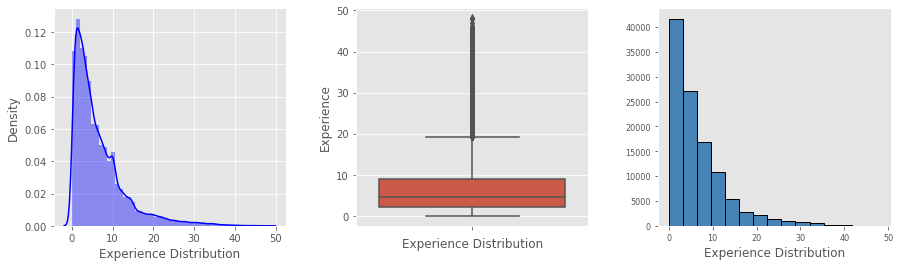

In [11]:
numerical_plots(train.Experience)

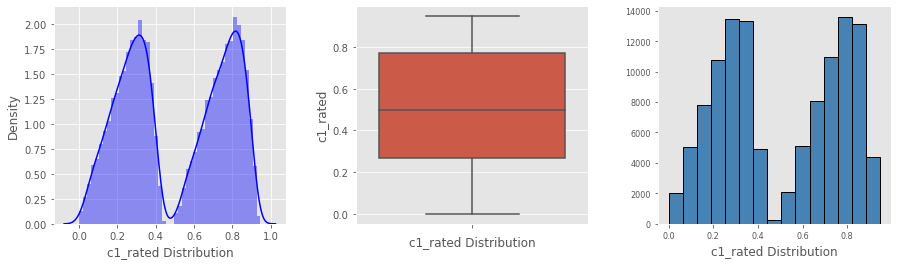

In [12]:
numerical_plots(train.c1_rated)

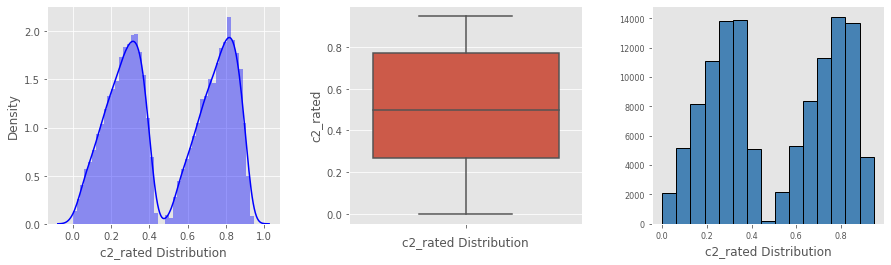

In [13]:
numerical_plots(train.c2_rated)

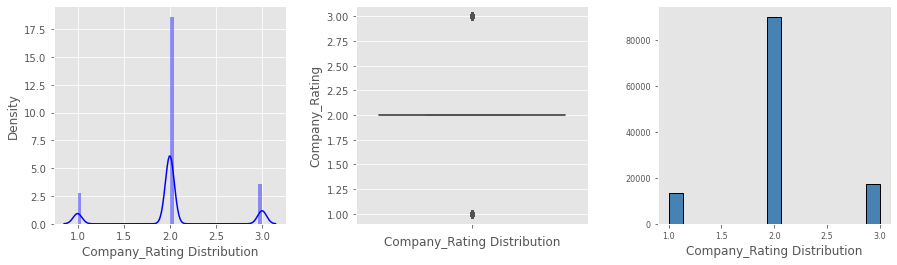

In [14]:
numerical_plots(train.Company_Rating)

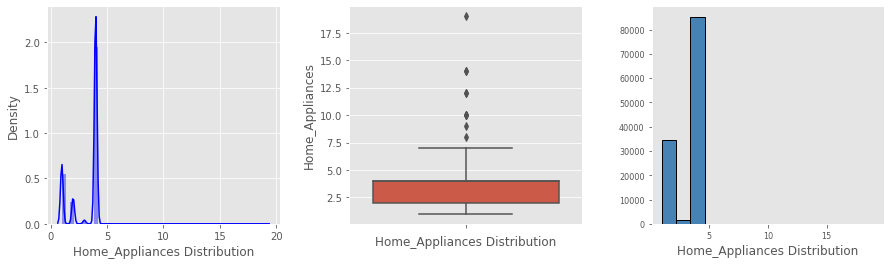

In [15]:
numerical_plots(train.Home_Appliances)

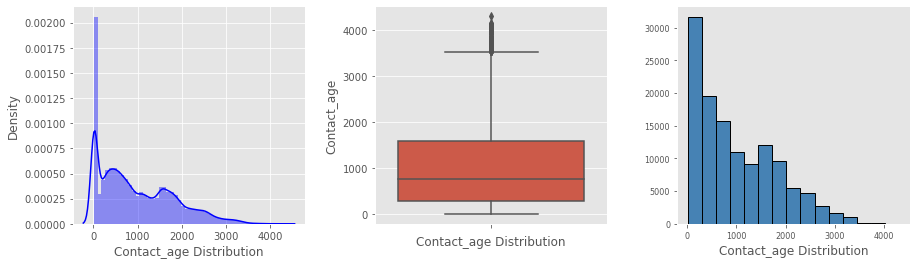

In [16]:
numerical_plots(train.Contact_age)

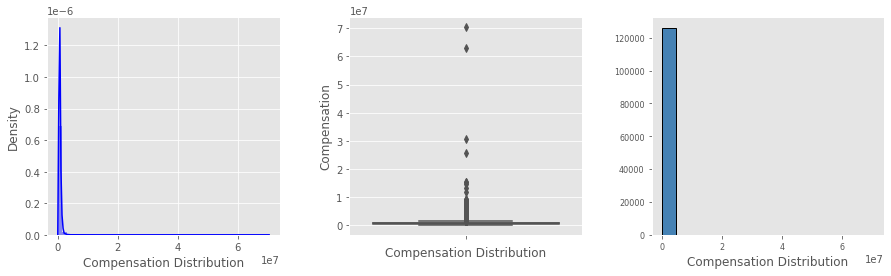

In [17]:
numerical_plots(train.Compensation)

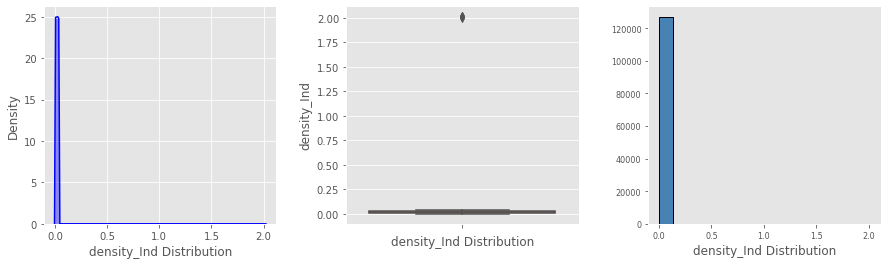

In [18]:
numerical_plots(train.density_Ind)

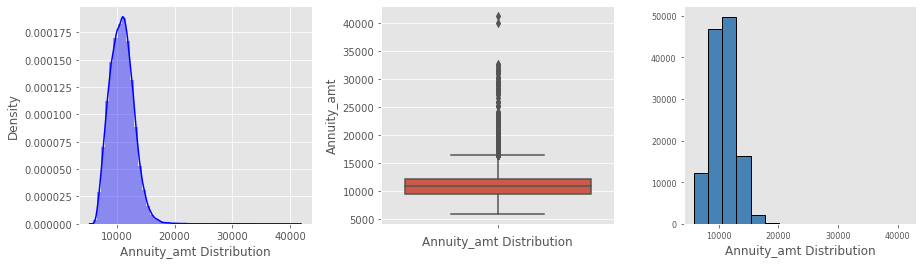

In [19]:
numerical_plots(train.Annuity_amt)

# INFERENCE

1) From the above plots we can able to look into the distribution and based on the distribution we can conclude whether which type of imputation is applicable for the respective attribute variable.

2) For Categorical variable we will try to impute by Mode for all the missing rows present in the dataset.

3) For Numerical variable we will look into the distribution and check whether the variable is skewed or not. If the dataset is not skewed we will impute by mode and if it is skewed we will replace by median.

4) From the above plots we infer that c1_rated and Company_Rating are the two variable whose distribution is not skewed and so hence we will replace by mean and for the rest of the other columns such as Experience,Home_Appliances,Contact_age,Compensation,density_Ind,Annuity_amt we will replace by median.

# IMPUTATION OF THE VARAIBLE BY MEAN,MEDIAN AND MODE

In [20]:
import pandas as pd

def conditional_impute(df,column_name,choice):
    try:
        if choice == 'mean':
            mean_value = df[column_name].mean()
            df[column_name].fillna(value=mean_value, inplace=True)
        elif choice == 'median':
            median_value = df[column_name].median()
            df[column_name].fillna(value=median_value, inplace=True)
        elif choice == 'mode':
            mode_value = df[column_name].mode()[0]
            df[column_name].fillna(value=mode_value, inplace=True)
    except Exception:
        print('Wrong Argument')
    return df

In [21]:
train=conditional_impute(train,'c1_rated','mean')
train=conditional_impute(train,'c2_rated','mean')
train=conditional_impute(train,'Company_Rating','mean')
train=conditional_impute(train,'Experience','median')
train=conditional_impute(train,'Home_Appliances','median')
train=conditional_impute(train,'Contact_age','median')
train=conditional_impute(train,'Compensation','median')
train=conditional_impute(train,'density_Ind','median')
train=conditional_impute(train,'Annuity_amt','median')
train=conditional_impute(train,'Job_Type','mode')
train=conditional_impute(train,'Vehicle_Status','mode')
train=conditional_impute(train,'Income_Alt','mode')
train=conditional_impute(train,'Credit_Inq','mode')
train=conditional_impute(train,'Prop_List','mode')

In [22]:
train

,ID,Compensation,Vehicle_Status,Loan_amt,Annuity_amt,density_Ind,Job_Type,Default_hist,Prop_List,Home_Appliances,Region_Type,Credit_Inq,Education_det,Marital_Stat,Gen,Credit_Lnks,Experience,Income_Alt,Day_Process,Ph.No,Type_Loan,Dependents,Company_Rating,Region,Age,hour_Process,Addr_permanent,Permanent_Addr_tag,c1_rated,c2_rated,Contact_age,Product_bought,Default
0,540071,801850.0,Y,658040.0,13816.52,0.0304,IT,ndf,Morethan_One,4.0,Metro,1,Grad,Married,F,1_to_3,0.9,Not_Specified,SAT,Yes,CLoan,3.0,2.0,East,46.0,10.0,Yes,No,0.077000,0.077,18.0,2.0,1.0
1,511643,884222.0,N,198075.0,11173.06,0.0194,IT,ndf,Morethan_One,1.0,Metro,2,Grad,Married,M,1_to_3,3.0,Not_Specified,wed,Yes,CLoan,3.0,1.0,North,46.0,12.0,Yes,Yes,0.184000,0.184,306.0,4.0,0.0
2,506688,284120.0,N,101056.0,8390.40,0.0118,Govt.,ndf,One,4.0,Metro,3,Other,Married,M,1_to_3,4.6,Not_Specified,mon,Yes,CLoan,2.0,3.0,North,57.0,5.0,Yes,Yes,0.538000,0.538,281.0,4.0,0.0
3,499360,341874.0,N,179008.0,7184.13,0.0373,Non-IT,df,None,2.0,Metro,1,Grad,Married,M,1_to_3,4.7,Not_Specified,wed,Yes,RLoan,4.0,2.0,South,39.0,12.0,Yes,Yes,0.505929,0.561,20.0,4.0,0.0
4,438350,1259895.0,Y,573715.0,13212.77,0.0138,Non-IT,ndf,Morethan_One,1.0,Rural,2,Grad,Married,F,4_to_6,6.9,Y,Sun,Yes,CLoan,3.0,1.0,North,32.0,16.0,Yes,Yes,0.505929,0.200,2339.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132435,435665,641706.0,Y,1048272.0,13181.84,0.0238,IT,ndf,One,4.0,Rural,3,Grad,Married,F,1_to_3,4.6,Not_Specified,SAT,Yes,CLoan,2.0,2.0,North,43.0,7.0,Yes,Yes,0.886000,0.886,2766.0,5.0,1.0
132436,509840,594160.0,N,640232.0,11911.93,0.0262,IT,ndf,One,4.0,Metro,3,Grad,Single,M,1_to_3,4.6,Not_Specified,Tue,Yes,CLoan,1.0,2.0,North,60.0,9.0,Yes,Yes,0.505929,0.641,2581.0,1.0,0.0
132437,504105,1471170.0,N,732914.0,11587.54,0.0204,Non-IT,ndf,One,4.0,Metro,1,Grad,Married,M,1_to_3,2.5,Not_Specified,SAT,Yes,CLoan,2.0,2.0,South,51.0,4.0,Yes,Yes,0.384000,0.384,1987.0,3.0,0.0
132438,430757,613585.0,N,528490.2,13008.76,0.0056,Non-IT,ndf,One,4.0,Metro,1,Grad,Widow,M,1_to_3,4.6,Y,mon,Yes,CLoan,1.0,2.0,Central,59.0,14.0,Yes,Yes,0.224000,0.224,1608.0,2.0,1.0


In [23]:
# Checking for the missing values after imputation
find_missing_values(train)

,Total,Percent


# Inference:

After imputation we found there are no missing values present in the dataset

# REMOVING OUTLIERS PRESENT IN THE DATASET

In [24]:
def remove_outliers(data):
    num_train = data.select_dtypes(include=["number"])
    cat_train = data.select_dtypes(exclude=["number"])
    from scipy import stats
    idx = np.all(stats.zscore(num_train) < 3, axis=1)
    train_cleaned = pd.concat([num_train.loc[idx], cat_train.loc[idx]], axis=1)
    return train_cleaned

In [25]:
train=remove_outliers(train)

In [26]:
train

,ID,Compensation,Loan_amt,Annuity_amt,density_Ind,Home_Appliances,Experience,Dependents,Company_Rating,Age,hour_Process,c1_rated,c2_rated,Contact_age,Product_bought,Default,Vehicle_Status,Job_Type,Default_hist,Prop_List,Region_Type,Credit_Inq,Education_det,Marital_Stat,Gen,Credit_Lnks,Income_Alt,Day_Process,Ph.No,Type_Loan,Region,Addr_permanent,Permanent_Addr_tag
0,540071,801850.0,658040.0,13816.52,0.0304,4.0,0.9,3.0,2.0,46.0,10.0,0.077000,0.077,18.0,2.0,1.0,Y,IT,ndf,Morethan_One,Metro,1,Grad,Married,F,1_to_3,Not_Specified,SAT,Yes,CLoan,East,Yes,No
1,511643,884222.0,198075.0,11173.06,0.0194,1.0,3.0,3.0,1.0,46.0,12.0,0.184000,0.184,306.0,4.0,0.0,N,IT,ndf,Morethan_One,Metro,2,Grad,Married,M,1_to_3,Not_Specified,wed,Yes,CLoan,North,Yes,Yes
2,506688,284120.0,101056.0,8390.40,0.0118,4.0,4.6,2.0,3.0,57.0,5.0,0.538000,0.538,281.0,4.0,0.0,N,Govt.,ndf,One,Metro,3,Other,Married,M,1_to_3,Not_Specified,mon,Yes,CLoan,North,Yes,Yes
3,499360,341874.0,179008.0,7184.13,0.0373,2.0,4.7,4.0,2.0,39.0,12.0,0.505929,0.561,20.0,4.0,0.0,N,Non-IT,df,None,Metro,1,Grad,Married,M,1_to_3,Not_Specified,wed,Yes,RLoan,South,Yes,Yes
4,438350,1259895.0,573715.0,13212.77,0.0138,1.0,6.9,3.0,1.0,32.0,16.0,0.505929,0.200,2339.0,6.0,0.0,Y,Non-IT,ndf,Morethan_One,Rural,2,Grad,Married,F,4_to_6,Y,Sun,Yes,CLoan,North,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132435,435665,641706.0,1048272.0,13181.84,0.0238,4.0,4.6,2.0,2.0,43.0,7.0,0.886000,0.886,2766.0,5.0,1.0,Y,IT,ndf,One,Rural,3,Grad,Married,F,1_to_3,Not_Specified,SAT,Yes,CLoan,North,Yes,Yes
132436,509840,594160.0,640232.0,11911.93,0.0262,4.0,4.6,1.0,2.0,60.0,9.0,0.505929,0.641,2581.0,1.0,0.0,N,IT,ndf,One,Metro,3,Grad,Single,M,1_to_3,Not_Specified,Tue,Yes,CLoan,North,Yes,Yes
132437,504105,1471170.0,732914.0,11587.54,0.0204,4.0,2.5,2.0,2.0,51.0,4.0,0.384000,0.384,1987.0,3.0,0.0,N,Non-IT,ndf,One,Metro,1,Grad,Married,M,1_to_3,Not_Specified,SAT,Yes,CLoan,South,Yes,Yes
132438,430757,613585.0,528490.2,13008.76,0.0056,4.0,4.6,1.0,2.0,59.0,14.0,0.224000,0.224,1608.0,2.0,1.0,N,Non-IT,ndf,One,Metro,1,Grad,Widow,M,1_to_3,Y,mon,Yes,CLoan,Central,Yes,Yes


# Inference:

We have used Z score method to remove outliere present in the dataset and we can able to see the dataset size has been reduced to 122713 Observations.

In [27]:
train=train.drop_duplicates()

In [28]:
train

,ID,Compensation,Loan_amt,Annuity_amt,density_Ind,Home_Appliances,Experience,Dependents,Company_Rating,Age,hour_Process,c1_rated,c2_rated,Contact_age,Product_bought,Default,Vehicle_Status,Job_Type,Default_hist,Prop_List,Region_Type,Credit_Inq,Education_det,Marital_Stat,Gen,Credit_Lnks,Income_Alt,Day_Process,Ph.No,Type_Loan,Region,Addr_permanent,Permanent_Addr_tag
0,540071,801850.0,658040.0,13816.52,0.0304,4.0,0.9,3.0,2.0,46.0,10.0,0.077000,0.077,18.0,2.0,1.0,Y,IT,ndf,Morethan_One,Metro,1,Grad,Married,F,1_to_3,Not_Specified,SAT,Yes,CLoan,East,Yes,No
1,511643,884222.0,198075.0,11173.06,0.0194,1.0,3.0,3.0,1.0,46.0,12.0,0.184000,0.184,306.0,4.0,0.0,N,IT,ndf,Morethan_One,Metro,2,Grad,Married,M,1_to_3,Not_Specified,wed,Yes,CLoan,North,Yes,Yes
2,506688,284120.0,101056.0,8390.40,0.0118,4.0,4.6,2.0,3.0,57.0,5.0,0.538000,0.538,281.0,4.0,0.0,N,Govt.,ndf,One,Metro,3,Other,Married,M,1_to_3,Not_Specified,mon,Yes,CLoan,North,Yes,Yes
3,499360,341874.0,179008.0,7184.13,0.0373,2.0,4.7,4.0,2.0,39.0,12.0,0.505929,0.561,20.0,4.0,0.0,N,Non-IT,df,None,Metro,1,Grad,Married,M,1_to_3,Not_Specified,wed,Yes,RLoan,South,Yes,Yes
4,438350,1259895.0,573715.0,13212.77,0.0138,1.0,6.9,3.0,1.0,32.0,16.0,0.505929,0.200,2339.0,6.0,0.0,Y,Non-IT,ndf,Morethan_One,Rural,2,Grad,Married,F,4_to_6,Y,Sun,Yes,CLoan,North,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132435,435665,641706.0,1048272.0,13181.84,0.0238,4.0,4.6,2.0,2.0,43.0,7.0,0.886000,0.886,2766.0,5.0,1.0,Y,IT,ndf,One,Rural,3,Grad,Married,F,1_to_3,Not_Specified,SAT,Yes,CLoan,North,Yes,Yes
132436,509840,594160.0,640232.0,11911.93,0.0262,4.0,4.6,1.0,2.0,60.0,9.0,0.505929,0.641,2581.0,1.0,0.0,N,IT,ndf,One,Metro,3,Grad,Single,M,1_to_3,Not_Specified,Tue,Yes,CLoan,North,Yes,Yes
132437,504105,1471170.0,732914.0,11587.54,0.0204,4.0,2.5,2.0,2.0,51.0,4.0,0.384000,0.384,1987.0,3.0,0.0,N,Non-IT,ndf,One,Metro,1,Grad,Married,M,1_to_3,Not_Specified,SAT,Yes,CLoan,South,Yes,Yes
132438,430757,613585.0,528490.2,13008.76,0.0056,4.0,4.6,1.0,2.0,59.0,14.0,0.224000,0.224,1608.0,2.0,1.0,N,Non-IT,ndf,One,Metro,1,Grad,Widow,M,1_to_3,Y,mon,Yes,CLoan,Central,Yes,Yes


# Inference:

No Duplicates is present in the dataset

# Changing the datatype present in the dataset

In [29]:
train['Compensation']=train['Compensation'].astype(int)
train['Loan_amt']=train['Loan_amt'].astype(int)
train['Home_Appliances']=train['Home_Appliances'].astype(int)
train['Dependents']=train['Dependents'].astype(int)
train['Company_Rating']=train['Company_Rating'].astype(int)
train['Age']=train['Age'].astype(int)
train['hour_Process']=train['hour_Process'].astype(int)
train['Product_bought']=train['Product_bought'].astype(int)
train['Default']=train['Default'].astype(int)

In [30]:
train

,ID,Compensation,Loan_amt,Annuity_amt,density_Ind,Home_Appliances,Experience,Dependents,Company_Rating,Age,hour_Process,c1_rated,c2_rated,Contact_age,Product_bought,Default,Vehicle_Status,Job_Type,Default_hist,Prop_List,Region_Type,Credit_Inq,Education_det,Marital_Stat,Gen,Credit_Lnks,Income_Alt,Day_Process,Ph.No,Type_Loan,Region,Addr_permanent,Permanent_Addr_tag
0,540071,801850,658040,13816.52,0.0304,4,0.9,3,2,46,10,0.077000,0.077,18.0,2,1,Y,IT,ndf,Morethan_One,Metro,1,Grad,Married,F,1_to_3,Not_Specified,SAT,Yes,CLoan,East,Yes,No
1,511643,884222,198075,11173.06,0.0194,1,3.0,3,1,46,12,0.184000,0.184,306.0,4,0,N,IT,ndf,Morethan_One,Metro,2,Grad,Married,M,1_to_3,Not_Specified,wed,Yes,CLoan,North,Yes,Yes
2,506688,284120,101056,8390.40,0.0118,4,4.6,2,3,57,5,0.538000,0.538,281.0,4,0,N,Govt.,ndf,One,Metro,3,Other,Married,M,1_to_3,Not_Specified,mon,Yes,CLoan,North,Yes,Yes
3,499360,341874,179008,7184.13,0.0373,2,4.7,4,2,39,12,0.505929,0.561,20.0,4,0,N,Non-IT,df,None,Metro,1,Grad,Married,M,1_to_3,Not_Specified,wed,Yes,RLoan,South,Yes,Yes
4,438350,1259895,573715,13212.77,0.0138,1,6.9,3,1,32,16,0.505929,0.200,2339.0,6,0,Y,Non-IT,ndf,Morethan_One,Rural,2,Grad,Married,F,4_to_6,Y,Sun,Yes,CLoan,North,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132435,435665,641706,1048272,13181.84,0.0238,4,4.6,2,2,43,7,0.886000,0.886,2766.0,5,1,Y,IT,ndf,One,Rural,3,Grad,Married,F,1_to_3,Not_Specified,SAT,Yes,CLoan,North,Yes,Yes
132436,509840,594160,640232,11911.93,0.0262,4,4.6,1,2,60,9,0.505929,0.641,2581.0,1,0,N,IT,ndf,One,Metro,3,Grad,Single,M,1_to_3,Not_Specified,Tue,Yes,CLoan,North,Yes,Yes
132437,504105,1471170,732914,11587.54,0.0204,4,2.5,2,2,51,4,0.384000,0.384,1987.0,3,0,N,Non-IT,ndf,One,Metro,1,Grad,Married,M,1_to_3,Not_Specified,SAT,Yes,CLoan,South,Yes,Yes
132438,430757,613585,528490,13008.76,0.0056,4,4.6,1,2,59,14,0.224000,0.224,1608.0,2,1,N,Non-IT,ndf,One,Metro,1,Grad,Widow,M,1_to_3,Y,mon,Yes,CLoan,Central,Yes,Yes


# Inference:

From the dataset we have changed the datatype from float to int for some of the columns

# Feature Selection and EDA 

In [31]:
def drop_low_standard_deviation(data):
    threshold = 0.2
    data=data.drop(data.std()[data.std() < threshold].index.values, axis=1)
    return data

In [32]:
drop_low_standard_deviation(train)

,ID,Compensation,Loan_amt,Annuity_amt,Home_Appliances,Experience,Dependents,Company_Rating,Age,hour_Process,c1_rated,c2_rated,Contact_age,Product_bought,Default,Vehicle_Status,Job_Type,Default_hist,Prop_List,Region_Type,Credit_Inq,Education_det,Marital_Stat,Gen,Credit_Lnks,Income_Alt,Day_Process,Ph.No,Type_Loan,Region,Addr_permanent,Permanent_Addr_tag
0,540071,801850,658040,13816.52,4,0.9,3,2,46,10,0.077000,0.077,18.0,2,1,Y,IT,ndf,Morethan_One,Metro,1,Grad,Married,F,1_to_3,Not_Specified,SAT,Yes,CLoan,East,Yes,No
1,511643,884222,198075,11173.06,1,3.0,3,1,46,12,0.184000,0.184,306.0,4,0,N,IT,ndf,Morethan_One,Metro,2,Grad,Married,M,1_to_3,Not_Specified,wed,Yes,CLoan,North,Yes,Yes
2,506688,284120,101056,8390.40,4,4.6,2,3,57,5,0.538000,0.538,281.0,4,0,N,Govt.,ndf,One,Metro,3,Other,Married,M,1_to_3,Not_Specified,mon,Yes,CLoan,North,Yes,Yes
3,499360,341874,179008,7184.13,2,4.7,4,2,39,12,0.505929,0.561,20.0,4,0,N,Non-IT,df,None,Metro,1,Grad,Married,M,1_to_3,Not_Specified,wed,Yes,RLoan,South,Yes,Yes
4,438350,1259895,573715,13212.77,1,6.9,3,1,32,16,0.505929,0.200,2339.0,6,0,Y,Non-IT,ndf,Morethan_One,Rural,2,Grad,Married,F,4_to_6,Y,Sun,Yes,CLoan,North,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132435,435665,641706,1048272,13181.84,4,4.6,2,2,43,7,0.886000,0.886,2766.0,5,1,Y,IT,ndf,One,Rural,3,Grad,Married,F,1_to_3,Not_Specified,SAT,Yes,CLoan,North,Yes,Yes
132436,509840,594160,640232,11911.93,4,4.6,1,2,60,9,0.505929,0.641,2581.0,1,0,N,IT,ndf,One,Metro,3,Grad,Single,M,1_to_3,Not_Specified,Tue,Yes,CLoan,North,Yes,Yes
132437,504105,1471170,732914,11587.54,4,2.5,2,2,51,4,0.384000,0.384,1987.0,3,0,N,Non-IT,ndf,One,Metro,1,Grad,Married,M,1_to_3,Not_Specified,SAT,Yes,CLoan,South,Yes,Yes
132438,430757,613585,528490,13008.76,4,4.6,1,2,59,14,0.224000,0.224,1608.0,2,1,N,Non-IT,ndf,One,Metro,1,Grad,Widow,M,1_to_3,Y,mon,Yes,CLoan,Central,Yes,Yes


# Association of Numerical variable with respect to target variable using correlation function

In [33]:
def strong_correlation(data):
    data=data.select_dtypes(include=np.number)
    data=data.corr()['Default'][:-1]
    strongly_correlated_features = data[abs(data)>0]
    strongly_correlated_features=pd.DataFrame(strongly_correlated_features)
    print("There is {} strongly correlated values with Default:\n{}".format(len(strongly_correlated_features), strongly_correlated_features))
    return strongly_correlated_features

In [34]:
strong_correlation(train)

There is 15 strongly correlated values with Default:
                  Default
ID              -0.001194
Compensation    -0.000791
Loan_amt        -0.004789
Annuity_amt     -0.001496
density_Ind      0.000983
Home_Appliances -0.002949
Experience      -0.019323
Dependents       0.002281
Company_Rating   0.013788
Age             -0.022435
hour_Process    -0.006833
c1_rated        -0.012601
c2_rated        -0.013262
Contact_age     -0.012508
Product_bought   0.007114


,Default
ID,-0.001194
Compensation,-0.000791
Loan_amt,-0.004789
Annuity_amt,-0.001496
density_Ind,0.000983
Home_Appliances,-0.002949
Experience,-0.019323
Dependents,0.002281
Company_Rating,0.013788
Age,-0.022435


So from the above we are retaining the above all numerical columns in our model and we also infer that c1_rated and c2_rated are exactly same so we will remove any of those columns

# INFERENCE

As a part of Feature Selection we are trying to reduce the no of features required for modelling the data since having more features which are not relavant for our model will make the model to perform badly so we will remove irrelavant features present in the dataset.

1) So first step we have removed the features which are having low standard deviation and one feature has been removed

2) For numerical variable we are looking for the correlation of the variables with respect to the target column and remove variable whose correlation value is less than 0.

# Finding Association of the Categorical Variables With respect to Target Variable based on Chi Square Statistics

In [35]:
import scipy.stats as s

def chi2(df,target,alpha):
    for i in df.columns:
        if df[i].dtype == 'O' and i != target:
            col = i
            ov = pd.crosstab(df[col], df[target])
            plt.style.use('ggplot')
            ov.plot(kind='bar', figsize=(5,5), stacked=True)
            plt.xlabel(i.title())
                 
            chi = s.chi2_contingency(ov)
            chi2_s = chi[0]
            p_value = chi[1]
            dof = chi[2]
            critical_value = s.chi2.ppf(q=1-alpha, df=dof)
            
            print('\n\033[1m\033[4m', col.upper(),':\033[0m \n')
            print('Significance Level = ', alpha)
            print('Degree of Freedom = ', dof)
            print('chi2 = ', chi2_s)
            print('Critical Value = ',critical_value)
            print('p-value = ', p_value)

            if chi2_s >=critical_value or p_value <= alpha :
                print('\nWe reject the null hypotheses, there is a relationship between the two variables \n')
            else:
                print('\nThere is no relationship between the two variables and the null hypotheses is retained \n')
            
            plt.show()

In [36]:
type_mapping2 = {0 : 'NON_DEFAULT', 1 : 'DEFAULT'}
train['Default'] = train['Default'].map(type_mapping2)


 VEHICLE_STATUS : 

Significance Level =  0.05
Degree of Freedom =  1
chi2 =  3.559593862286918
Critical Value =  3.841458820694124
p-value =  0.05920222229092789

There is no relationship between the two variables and the null hypotheses is retained 



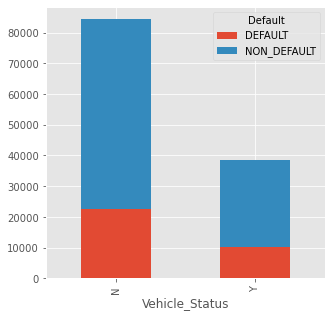


 JOB_TYPE : 

Significance Level =  0.05
Degree of Freedom =  2
chi2 =  1.6439362043599974
Critical Value =  5.991464547107979
p-value =  0.43956569243706367

There is no relationship between the two variables and the null hypotheses is retained 



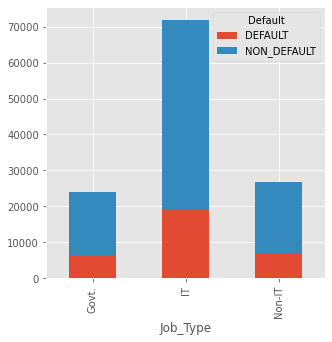


 DEFAULT_HIST : 

Significance Level =  0.05
Degree of Freedom =  1
chi2 =  0.022558819481760882
Critical Value =  3.841458820694124
p-value =  0.8806100313639222

There is no relationship between the two variables and the null hypotheses is retained 



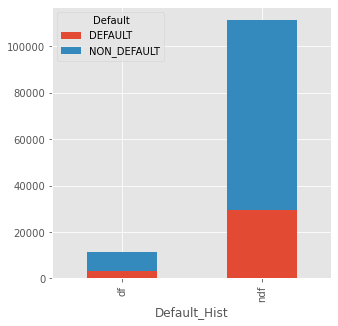


 PROP_LIST : 

Significance Level =  0.05
Degree of Freedom =  2
chi2 =  0.5330210590776013
Critical Value =  5.991464547107979
p-value =  0.7660479375522461

There is no relationship between the two variables and the null hypotheses is retained 



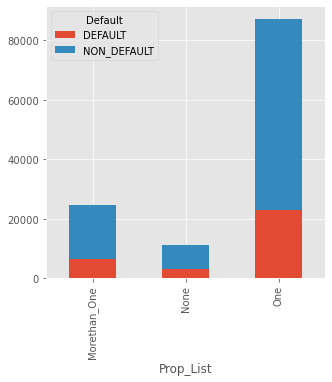


 REGION_TYPE : 

Significance Level =  0.05
Degree of Freedom =  2
chi2 =  1.3324428686412277
Critical Value =  5.991464547107979
p-value =  0.5136457598363664

There is no relationship between the two variables and the null hypotheses is retained 



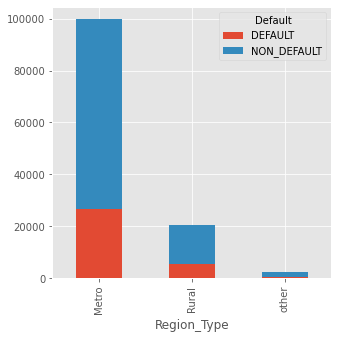


 CREDIT_INQ : 

Significance Level =  0.05
Degree of Freedom =  3
chi2 =  26.15037528926266
Critical Value =  7.814727903251179
p-value =  8.87038594561091e-06

We reject the null hypotheses, there is a relationship between the two variables 



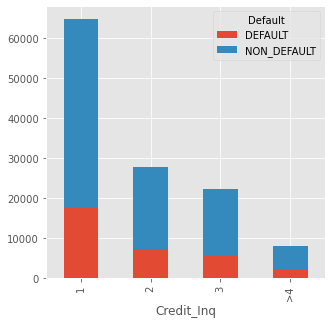


 EDUCATION_DET : 

Significance Level =  0.05
Degree of Freedom =  2
chi2 =  29.10713764180084
Critical Value =  5.991464547107979
p-value =  4.780412453184384e-07

We reject the null hypotheses, there is a relationship between the two variables 



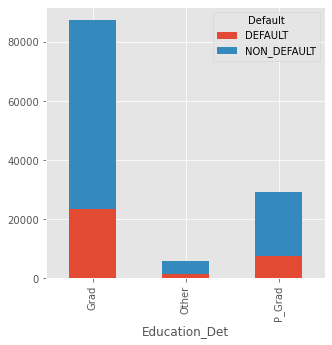


 MARITAL_STAT : 

Significance Level =  0.05
Degree of Freedom =  3
chi2 =  2.2092743378597097
Critical Value =  7.814727903251179
p-value =  0.530123926868791

There is no relationship between the two variables and the null hypotheses is retained 



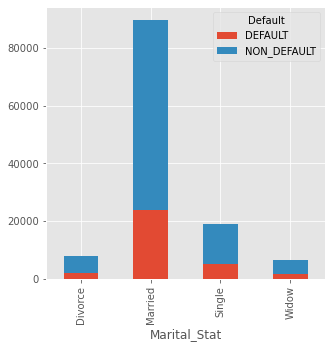


 GEN : 

Significance Level =  0.05
Degree of Freedom =  1
chi2 =  30.324935941736246
Critical Value =  3.841458820694124
p-value =  3.653981006962202e-08

We reject the null hypotheses, there is a relationship between the two variables 



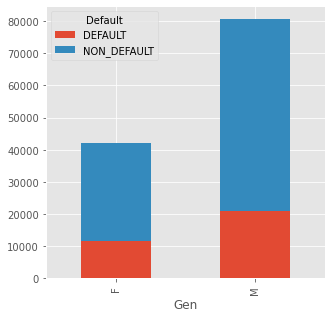


 CREDIT_LNKS : 

Significance Level =  0.05
Degree of Freedom =  2
chi2 =  15.475337335694062
Critical Value =  5.991464547107979
p-value =  0.0004360870546807426

We reject the null hypotheses, there is a relationship between the two variables 



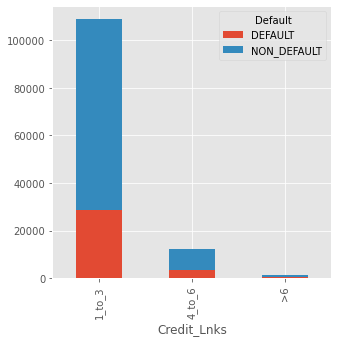


 INCOME_ALT : 

Significance Level =  0.05
Degree of Freedom =  1
chi2 =  2.22869250107544
Critical Value =  3.841458820694124
p-value =  0.1354684428520139

There is no relationship between the two variables and the null hypotheses is retained 



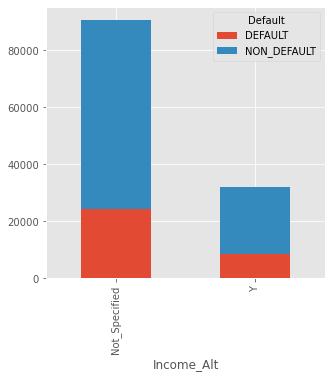


 DAY_PROCESS : 

Significance Level =  0.05
Degree of Freedom =  6
chi2 =  4.8479410876411855
Critical Value =  12.591587243743977
p-value =  0.5634587177024333

There is no relationship between the two variables and the null hypotheses is retained 



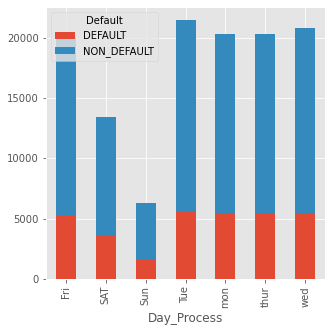


 PH.NO : 

Significance Level =  0.05
Degree of Freedom =  1
chi2 =  8.93729721909177
Critical Value =  3.841458820694124
p-value =  0.0027940584602438754

We reject the null hypotheses, there is a relationship between the two variables 



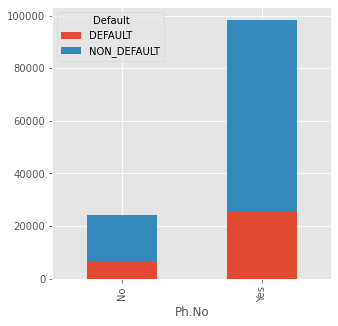


 TYPE_LOAN : 

Significance Level =  0.05
Degree of Freedom =  1
chi2 =  2.8534779182181302
Critical Value =  3.841458820694124
p-value =  0.09117650025019355

There is no relationship between the two variables and the null hypotheses is retained 



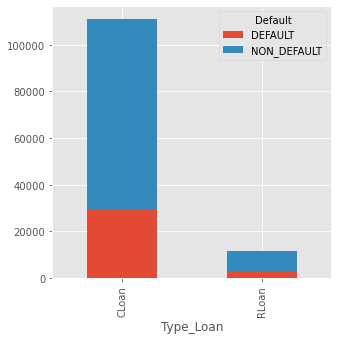


 REGION : 

Significance Level =  0.05
Degree of Freedom =  3
chi2 =  11.946242097243521
Critical Value =  7.814727903251179
p-value =  0.007569599463395339

We reject the null hypotheses, there is a relationship between the two variables 



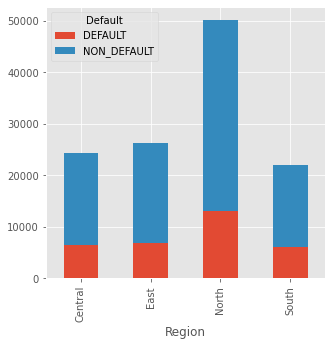


 ADDR_PERMANENT : 

Significance Level =  0.05
Degree of Freedom =  1
chi2 =  37.05509083740827
Critical Value =  3.841458820694124
p-value =  1.148383656590878e-09

We reject the null hypotheses, there is a relationship between the two variables 



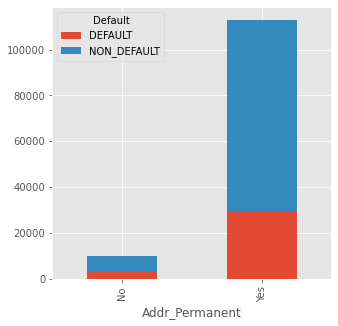


 PERMANENT_ADDR_TAG : 

Significance Level =  0.05
Degree of Freedom =  1
chi2 =  1.584410934293348
Critical Value =  3.841458820694124
p-value =  0.20812647636699916

There is no relationship between the two variables and the null hypotheses is retained 



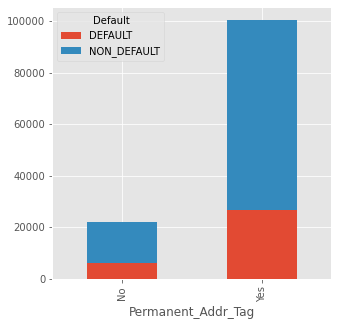

In [37]:
chi2(train,'Default',0.05)

# INFERENCE

We have applied Chi Square Test and we have looked for the association of all the cateorical variable with respect to the target variable (i.e Default) and from the above result summary we interpret the following.

1) Credit Info , EDUCATION_DET, GEN , CREDIT_LNKS, PH.NO ,REGION,ADDR_PERMANENT are the varaibles which are having strong association with respect to the target variable so from the list of categorical variables present in the dataset we will try to retain these column alone for our model building and remove rest of the categorical variables

In [38]:
train.head(5)

,ID,Compensation,Loan_amt,Annuity_amt,density_Ind,Home_Appliances,Experience,Dependents,Company_Rating,Age,hour_Process,c1_rated,c2_rated,Contact_age,Product_bought,Default,Vehicle_Status,Job_Type,Default_hist,Prop_List,Region_Type,Credit_Inq,Education_det,Marital_Stat,Gen,Credit_Lnks,Income_Alt,Day_Process,Ph.No,Type_Loan,Region,Addr_permanent,Permanent_Addr_tag
0,540071,801850,658040,13816.52,0.0304,4,0.9,3,2,46,10,0.077000,0.077,18.0,2,DEFAULT,Y,IT,ndf,Morethan_One,Metro,1,Grad,Married,F,1_to_3,Not_Specified,SAT,Yes,CLoan,East,Yes,No
1,511643,884222,198075,11173.06,0.0194,1,3.0,3,1,46,12,0.184000,0.184,306.0,4,NON_DEFAULT,N,IT,ndf,Morethan_One,Metro,2,Grad,Married,M,1_to_3,Not_Specified,wed,Yes,CLoan,North,Yes,Yes
2,506688,284120,101056,8390.40,0.0118,4,4.6,2,3,57,5,0.538000,0.538,281.0,4,NON_DEFAULT,N,Govt.,ndf,One,Metro,3,Other,Married,M,1_to_3,Not_Specified,mon,Yes,CLoan,North,Yes,Yes
3,499360,341874,179008,7184.13,0.0373,2,4.7,4,2,39,12,0.505929,0.561,20.0,4,NON_DEFAULT,N,Non-IT,df,None,Metro,1,Grad,Married,M,1_to_3,Not_Specified,wed,Yes,RLoan,South,Yes,Yes
4,438350,1259895,573715,13212.77,0.0138,1,6.9,3,1,32,16,0.505929,0.200,2339.0,6,NON_DEFAULT,Y,Non-IT,ndf,Morethan_One,Rural,2,Grad,Married,F,4_to_6,Y,Sun,Yes,CLoan,North,Yes,Yes


In [39]:
train.dtypes

ID                      int64
Compensation            int32
Loan_amt                int32
Annuity_amt           float64
density_Ind           float64
Home_Appliances         int32
Experience            float64
Dependents              int32
Company_Rating          int32
Age                     int32
hour_Process            int32
c1_rated              float64
c2_rated              float64
Contact_age           float64
Product_bought          int32
Default                object
Vehicle_Status         object
Job_Type               object
Default_hist           object
Prop_List              object
Region_Type            object
Credit_Inq             object
Education_det          object
Marital_Stat           object
Gen                    object
Credit_Lnks            object
Income_Alt             object
Day_Process            object
Ph.No                  object
Type_Loan              object
Region                 object
Addr_permanent         object
Permanent_Addr_tag     object
dtype: obj

# Selecting only the relavant columns after initial Feature reduction

In [40]:
train=train[['Compensation','Loan_amt','Annuity_amt','density_Ind','Home_Appliances','Experience','Dependents','Company_Rating','Age','hour_Process','c1_rated','Contact_age','Product_bought','Education_det','Gen','Credit_Lnks','Income_Alt','Ph.No','Type_Loan','Region','Addr_permanent','Default']]

In [41]:
train.head(5)

,Compensation,Loan_amt,Annuity_amt,density_Ind,Home_Appliances,Experience,Dependents,Company_Rating,Age,hour_Process,c1_rated,Contact_age,Product_bought,Education_det,Gen,Credit_Lnks,Income_Alt,Ph.No,Type_Loan,Region,Addr_permanent,Default
0,801850,658040,13816.52,0.0304,4,0.9,3,2,46,10,0.077000,18.0,2,Grad,F,1_to_3,Not_Specified,Yes,CLoan,East,Yes,DEFAULT
1,884222,198075,11173.06,0.0194,1,3.0,3,1,46,12,0.184000,306.0,4,Grad,M,1_to_3,Not_Specified,Yes,CLoan,North,Yes,NON_DEFAULT
2,284120,101056,8390.40,0.0118,4,4.6,2,3,57,5,0.538000,281.0,4,Other,M,1_to_3,Not_Specified,Yes,CLoan,North,Yes,NON_DEFAULT
3,341874,179008,7184.13,0.0373,2,4.7,4,2,39,12,0.505929,20.0,4,Grad,M,1_to_3,Not_Specified,Yes,RLoan,South,Yes,NON_DEFAULT
4,1259895,573715,13212.77,0.0138,1,6.9,3,1,32,16,0.505929,2339.0,6,Grad,F,4_to_6,Y,Yes,CLoan,North,Yes,NON_DEFAULT


In [42]:
# replacing values
train['Default'].replace(['NON_DEFAULT', 'DEFAULT'],[0, 1], inplace=True)

In [43]:
train.head(5)

,Compensation,Loan_amt,Annuity_amt,density_Ind,Home_Appliances,Experience,Dependents,Company_Rating,Age,hour_Process,c1_rated,Contact_age,Product_bought,Education_det,Gen,Credit_Lnks,Income_Alt,Ph.No,Type_Loan,Region,Addr_permanent,Default
0,801850,658040,13816.52,0.0304,4,0.9,3,2,46,10,0.077000,18.0,2,Grad,F,1_to_3,Not_Specified,Yes,CLoan,East,Yes,1
1,884222,198075,11173.06,0.0194,1,3.0,3,1,46,12,0.184000,306.0,4,Grad,M,1_to_3,Not_Specified,Yes,CLoan,North,Yes,0
2,284120,101056,8390.40,0.0118,4,4.6,2,3,57,5,0.538000,281.0,4,Other,M,1_to_3,Not_Specified,Yes,CLoan,North,Yes,0
3,341874,179008,7184.13,0.0373,2,4.7,4,2,39,12,0.505929,20.0,4,Grad,M,1_to_3,Not_Specified,Yes,RLoan,South,Yes,0
4,1259895,573715,13212.77,0.0138,1,6.9,3,1,32,16,0.505929,2339.0,6,Grad,F,4_to_6,Y,Yes,CLoan,North,Yes,0


In [44]:
type_mapping2 = {0 : 'NON_DEFAULT', 1 : 'DEFAULT'}
train['Default'] = train['Default'].map(type_mapping2)

In [45]:
train.head(5)

,Compensation,Loan_amt,Annuity_amt,density_Ind,Home_Appliances,Experience,Dependents,Company_Rating,Age,hour_Process,c1_rated,Contact_age,Product_bought,Education_det,Gen,Credit_Lnks,Income_Alt,Ph.No,Type_Loan,Region,Addr_permanent,Default
0,801850,658040,13816.52,0.0304,4,0.9,3,2,46,10,0.077000,18.0,2,Grad,F,1_to_3,Not_Specified,Yes,CLoan,East,Yes,DEFAULT
1,884222,198075,11173.06,0.0194,1,3.0,3,1,46,12,0.184000,306.0,4,Grad,M,1_to_3,Not_Specified,Yes,CLoan,North,Yes,NON_DEFAULT
2,284120,101056,8390.40,0.0118,4,4.6,2,3,57,5,0.538000,281.0,4,Other,M,1_to_3,Not_Specified,Yes,CLoan,North,Yes,NON_DEFAULT
3,341874,179008,7184.13,0.0373,2,4.7,4,2,39,12,0.505929,20.0,4,Grad,M,1_to_3,Not_Specified,Yes,RLoan,South,Yes,NON_DEFAULT
4,1259895,573715,13212.77,0.0138,1,6.9,3,1,32,16,0.505929,2339.0,6,Grad,F,4_to_6,Y,Yes,CLoan,North,Yes,NON_DEFAULT


# UNIVARIATE CATEGORICAL ANALYSIS

In [46]:
#Defining funtion for ploting categorical attributes

def categorical_plots(var, data):
        
    #Adjustment of plots, bigger size and space b/w subplots
    
    fig = plt.figure(figsize=(15,5))
    fig.subplots_adjust(wspace=0.3)
    
    plt.style.use('ggplot')
        
    #1st Plot:  Bar plot     
        
    plt.subplot(1,2,1)
    sns.countplot(x=var, data= data)
    plt.xticks(rotation = 45, horizontalalignment='right')
    plt.xlabel(var.name + ' Distribution')
    

    #2nd Plot: PIE Chart
    
    labels =var.value_counts().index  #Labels that will be written against slices in pie charts
    
    #For the slice with highest value to be exploded, explode parameter is passed. Using for loop to make a tuple of 
    # number of slice using len(unique) and exploding the first slice by mentioning 0.1 at first index. Atlast converted list to tuple
    
    a=[0.1]
    for i in range ((len(var.unique()))-1):
        a.append(0)

    explode1= tuple(a)
    #if var.name != 'Customer Name':
    ax1 = plt.subplot(1,2,2)
    ax1.pie(var.value_counts(), labels=labels,autopct='%1.1f%%', shadow=True,explode= explode1 )
    ax1.axis('equal')
    plt.xlabel(var.name + ' Distribution')
    plt.legend()
        
    show=plt.show()
    
    return(show)

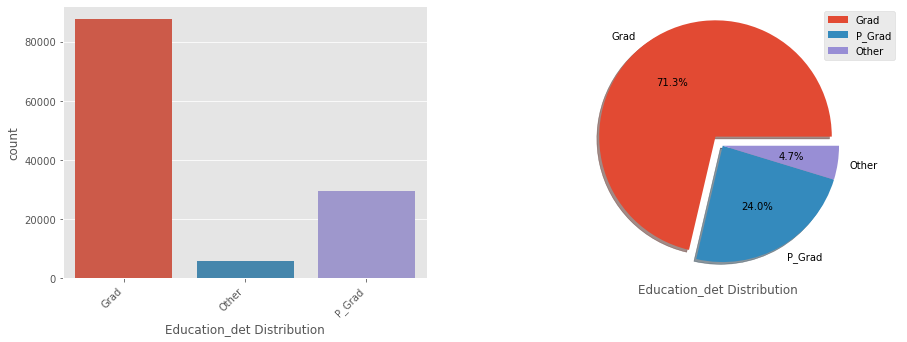

In [47]:
categorical_plots(train.Education_det,train)

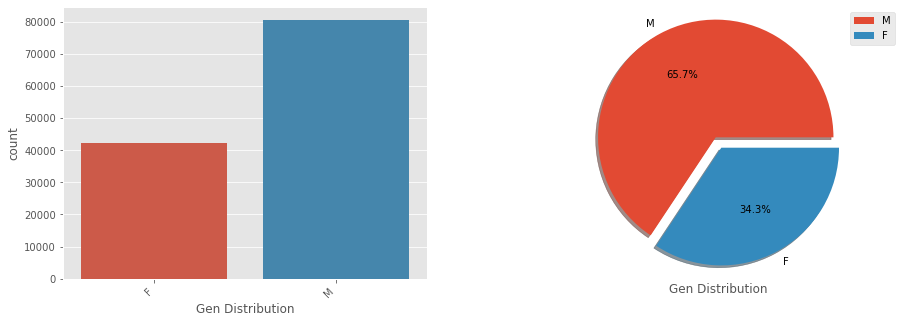

In [48]:
categorical_plots(train.Gen,train)

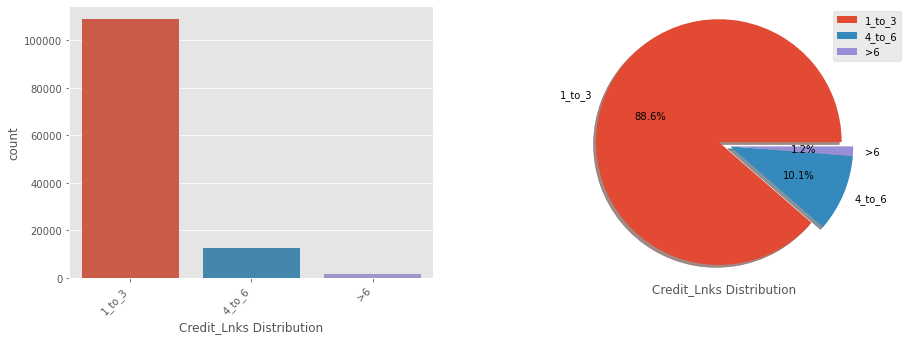

In [49]:
categorical_plots(train.Credit_Lnks,train)

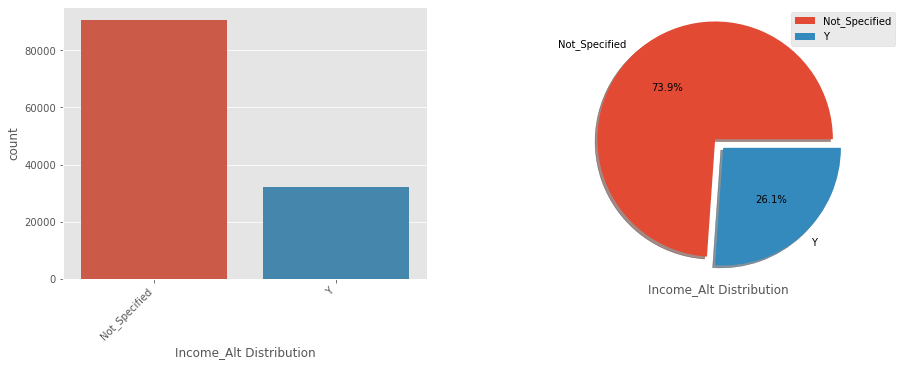

In [50]:
categorical_plots(train.Income_Alt,train)

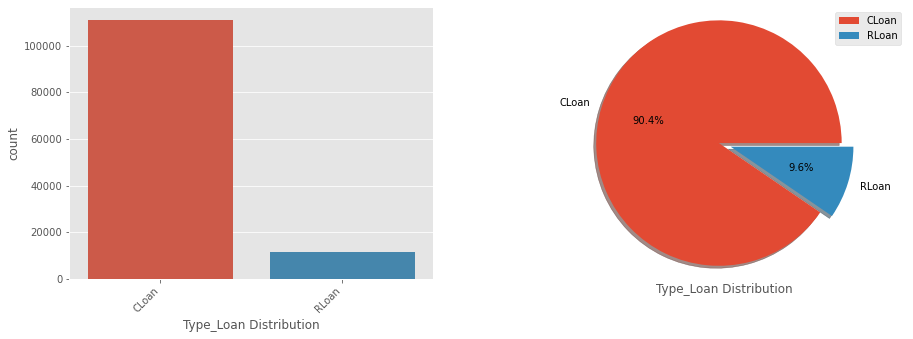

In [51]:
categorical_plots(train.Type_Loan,train)

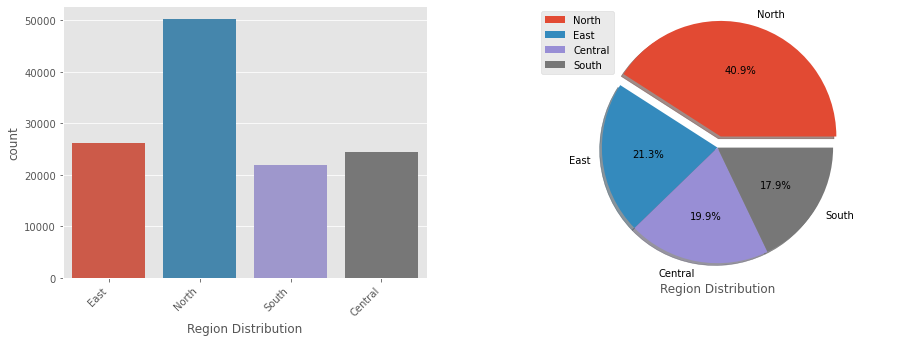

In [52]:
categorical_plots(train.Region,train)

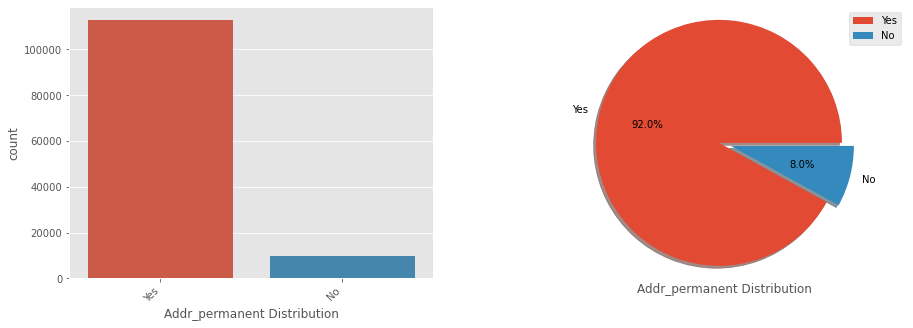

In [53]:
categorical_plots(train.Addr_permanent,train)

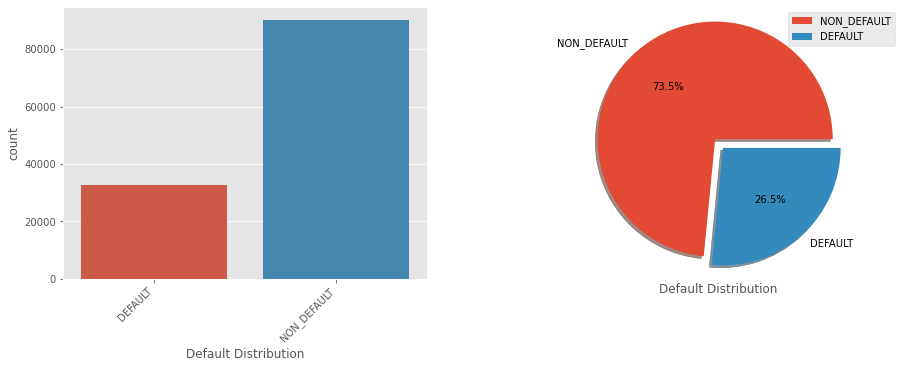

In [54]:
categorical_plots(train.Default,train)

# Bivariate Categorical Analysis

In [55]:
# BIVARIATE Countplot on two categorical variable
def bivariate_categorical(data,column1,column2):
    sns.countplot(data=data,x=data[column1],hue=data[column2])
    show=plt.show()
    return show

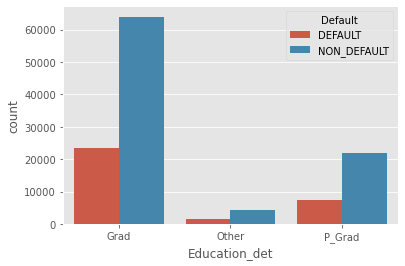

In [56]:
bivariate_categorical(train,'Education_det','Default')

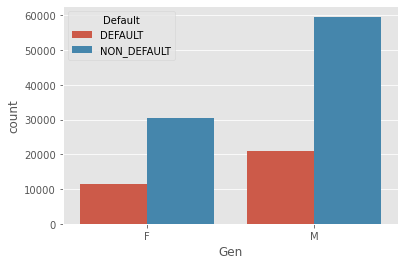

In [57]:
bivariate_categorical(train,'Gen','Default')

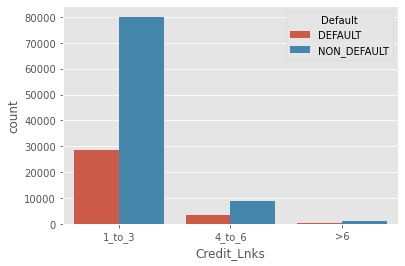

In [58]:
bivariate_categorical(train,'Credit_Lnks','Default')

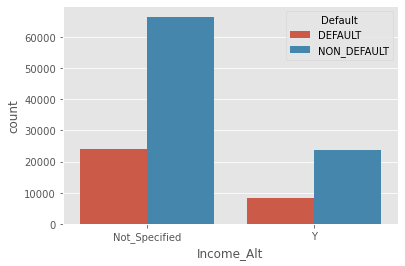

In [59]:
bivariate_categorical(train,'Income_Alt','Default')

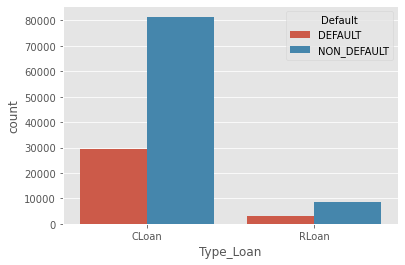

In [60]:
bivariate_categorical(train,'Type_Loan','Default')

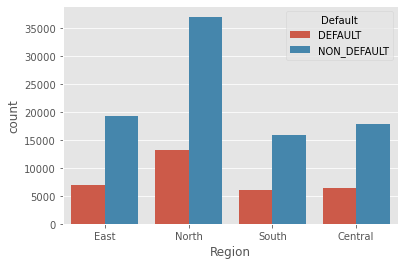

In [61]:
bivariate_categorical(train,'Region','Default')

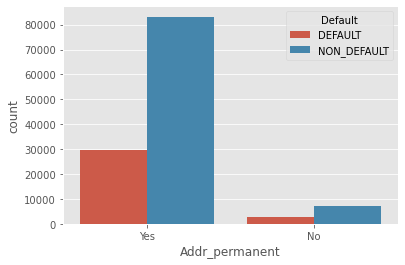

In [62]:
bivariate_categorical(train,'Addr_permanent','Default')

In [63]:
def crosstab(data,column1,column2):
    data[column1].unique()
    data = pd.crosstab(data[column1], data[column2]).apply(lambda x: x/x.sum() * 100)
    return data

In [64]:
crosstab(train,'Education_det','Default')

Default,DEFAULT,NON_DEFAULT
Education_det,,
Grad,72.343496,70.980231
Other,4.798747,4.674846
P_Grad,22.857757,24.344922


In [65]:
crosstab(train,'Gen','Default')

Default,DEFAULT,NON_DEFAULT
Gen,,
F,35.574591,33.882097
M,64.425409,66.117903


In [66]:
crosstab(train,'Credit_Lnks','Default')

Default,DEFAULT,NON_DEFAULT
Credit_Lnks,,
1_to_3,88.084492,88.791019
4_to_6,10.705843,9.946529
>6,1.209665,1.262453


In [67]:
crosstab(train,'Income_Alt','Default')

Default,DEFAULT,NON_DEFAULT
Income_Alt,,
Not_Specified,74.204047,73.778039
Y,25.795953,26.221961


In [68]:
crosstab(train,'Type_Loan','Default')

Default,DEFAULT,NON_DEFAULT
Type_Loan,,
CLoan,90.684965,90.361873
RLoan,9.315035,9.638127


In [69]:
crosstab(train,'Region','Default')

Default,DEFAULT,NON_DEFAULT
Region,,
Central,19.922631,19.846464
East,21.233613,21.371836
North,40.373338,41.108473
South,18.470418,17.673227


In [70]:
crosstab(train,'Addr_permanent','Default')

Default,DEFAULT,NON_DEFAULT
Addr_permanent,,
No,8.790028,7.720042
Yes,91.209972,92.279958


<AxesSubplot:xlabel='Loan_amt', ylabel='Count'>

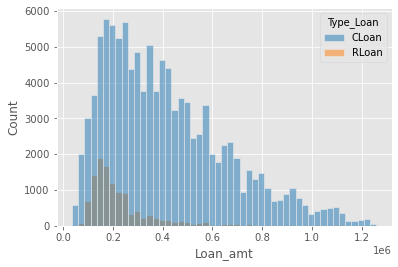

In [71]:
#To determine the relationship between the contract type of the loan and  the loan amount 
sns.histplot( x = train['Loan_amt'],hue = train['Type_Loan'],binwidth=25000,palette = ("tab10"))

In [72]:
train.head(5)

,Compensation,Loan_amt,Annuity_amt,density_Ind,Home_Appliances,Experience,Dependents,Company_Rating,Age,hour_Process,c1_rated,Contact_age,Product_bought,Education_det,Gen,Credit_Lnks,Income_Alt,Ph.No,Type_Loan,Region,Addr_permanent,Default
0,801850,658040,13816.52,0.0304,4,0.9,3,2,46,10,0.077000,18.0,2,Grad,F,1_to_3,Not_Specified,Yes,CLoan,East,Yes,DEFAULT
1,884222,198075,11173.06,0.0194,1,3.0,3,1,46,12,0.184000,306.0,4,Grad,M,1_to_3,Not_Specified,Yes,CLoan,North,Yes,NON_DEFAULT
2,284120,101056,8390.40,0.0118,4,4.6,2,3,57,5,0.538000,281.0,4,Other,M,1_to_3,Not_Specified,Yes,CLoan,North,Yes,NON_DEFAULT
3,341874,179008,7184.13,0.0373,2,4.7,4,2,39,12,0.505929,20.0,4,Grad,M,1_to_3,Not_Specified,Yes,RLoan,South,Yes,NON_DEFAULT
4,1259895,573715,13212.77,0.0138,1,6.9,3,1,32,16,0.505929,2339.0,6,Grad,F,4_to_6,Y,Yes,CLoan,North,Yes,NON_DEFAULT


In [73]:
# replacing values
train['Default'].replace(['NON_DEFAULT', 'DEFAULT'],[0, 1], inplace=True)

# FEATURE SELECTION BASED ON THE VOTING USING DIFFERENT TECHNIQUES:

In [74]:
# Transforming Categorical variable to Numerical Variable

def preprocess_data(data):
    train['Education_det'].replace(['Grad', 'P_Grad','Other'],[0,1,2], inplace=True)
    train['Gen'].replace(['M', 'F'],[0, 1], inplace=True)
    train['Credit_Lnks'].replace(['1_to_3', '4_to_6','>6'],[0,1,2], inplace=True)
    train['Income_Alt'].replace(['Not_Specified', 'Y'],[0, 1], inplace=True)
    train['Ph.No'].replace(['No', 'Yes'],[0, 1], inplace=True)
    train['Type_Loan'].replace(['CLoan', 'RLoan'],[0, 1], inplace=True)
    train['Region'].replace(['Central','East','North','South'],[0,1,2,3], inplace=True)
    train['Addr_permanent'].replace(['No', 'Yes'],[0, 1], inplace=True)
    return train

In [75]:
preprocess_data(train)

,Compensation,Loan_amt,Annuity_amt,density_Ind,Home_Appliances,Experience,Dependents,Company_Rating,Age,hour_Process,c1_rated,Contact_age,Product_bought,Education_det,Gen,Credit_Lnks,Income_Alt,Ph.No,Type_Loan,Region,Addr_permanent,Default
0,801850,658040,13816.52,0.0304,4,0.9,3,2,46,10,0.077000,18.0,2,0,1,0,0,1,0,1,1,1
1,884222,198075,11173.06,0.0194,1,3.0,3,1,46,12,0.184000,306.0,4,0,0,0,0,1,0,2,1,0
2,284120,101056,8390.40,0.0118,4,4.6,2,3,57,5,0.538000,281.0,4,2,0,0,0,1,0,2,1,0
3,341874,179008,7184.13,0.0373,2,4.7,4,2,39,12,0.505929,20.0,4,0,0,0,0,1,1,3,1,0
4,1259895,573715,13212.77,0.0138,1,6.9,3,1,32,16,0.505929,2339.0,6,0,1,1,1,1,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132435,641706,1048272,13181.84,0.0238,4,4.6,2,2,43,7,0.886000,2766.0,5,0,1,0,0,1,0,2,1,1
132436,594160,640232,11911.93,0.0262,4,4.6,1,2,60,9,0.505929,2581.0,1,0,0,0,0,1,0,2,1,0
132437,1471170,732914,11587.54,0.0204,4,2.5,2,2,51,4,0.384000,1987.0,3,0,0,0,0,1,0,3,1,0
132438,613585,528490,13008.76,0.0056,4,4.6,1,2,59,14,0.224000,1608.0,2,0,0,0,1,1,0,0,1,1


In [76]:
train.dtypes

Compensation         int32
Loan_amt             int32
Annuity_amt        float64
density_Ind        float64
Home_Appliances      int32
Experience         float64
Dependents           int32
Company_Rating       int32
Age                  int32
hour_Process         int32
c1_rated           float64
Contact_age        float64
Product_bought       int32
Education_det        int64
Gen                  int64
Credit_Lnks          int64
Income_Alt           int64
Ph.No                int64
Type_Loan            int64
Region               int64
Addr_permanent       int64
Default              int64
dtype: object

# Variable Selection using Weight of Evidence and Information Value

In [77]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [78]:
final_iv, IV = data_vars(train,train.Default)

In [79]:
IV = IV.rename(columns={'VAR_NAME':'index'})

In [80]:
IV.sort_values(['IV'],ascending=0)

,index,IV
1,Age,2.443913e-03
9,Experience,1.927499e-03
0,Addr_permanent,1.513612e-03
10,Gen,1.263892e-03
5,Contact_age,6.919774e-04
3,Company_Rating,6.042589e-04
16,Region,4.292880e-04
14,Ph.No,3.730534e-04
15,Product_bought,2.796704e-04
20,hour_Process,1.509779e-04


In [81]:
X=train[['Compensation','Loan_amt','Annuity_amt','density_Ind','Home_Appliances','Experience','Dependents','Company_Rating','Age','hour_Process','c1_rated','Contact_age','Product_bought','Education_det','Gen','Credit_Lnks','Income_Alt','Ph.No','Type_Loan','Region','Addr_permanent']]
y=train['Default']

# Variable Importance using Random Forest Classifier

In [82]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(X,y)

preds = clf.predict(X)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,y)
print(accuracy)

1.0


In [83]:
from pandas import DataFrame
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=X.columns)

In [84]:
VI = VI.reset_index()

In [85]:
VI.sort_values(['RF'],ascending=0)

,index,RF
1,Loan_amt,0.102198
2,Annuity_amt,0.101864
0,Compensation,0.101362
3,density_Ind,0.097047
11,Contact_age,0.096128
10,c1_rated,0.093763
5,Experience,0.076823
8,Age,0.072950
9,hour_Process,0.063313
12,Product_bought,0.049181


# Variable Selection using Recursive Feature Elimination

In [86]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model)
fit = rfe.fit(X, y)

In [87]:
from pandas import DataFrame
Selected = DataFrame(rfe.support_, columns = ["RFE"], index=X.columns)
Selected = Selected.reset_index()

In [88]:
Selected[Selected['RFE'] == True]

,index,RFE
0,Compensation,True
1,Loan_amt,True
2,Annuity_amt,True
4,Home_Appliances,True
5,Experience,True
7,Company_Rating,True
8,Age,True
9,hour_Process,True
11,Contact_age,True
12,Product_bought,True


# Variable Importance - Extratrees Classifier

In [89]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X, y)

print(model.feature_importances_)

[0.08189968 0.08242898 0.08261862 0.08246296 0.01947091 0.072705
 0.03692407 0.02266415 0.07736205 0.07684578 0.08139617 0.08187364
 0.06937566 0.01936251 0.00948436 0.01563535 0.01668112 0.01225094
 0.01086458 0.04253717 0.0051563 ]


In [90]:
from pandas import DataFrame
FI = DataFrame(model.feature_importances_, columns = ["Extratrees"], index=X.columns)

In [91]:
FI = FI.reset_index()

In [92]:
FI.sort_values(['Extratrees'],ascending=0)

,index,Extratrees
2,Annuity_amt,0.082619
3,density_Ind,0.082463
1,Loan_amt,0.082429
0,Compensation,0.081900
11,Contact_age,0.081874
10,c1_rated,0.081396
8,Age,0.077362
9,hour_Process,0.076846
5,Experience,0.072705
12,Product_bought,0.069376


# Variable Selection using Kbest

In [93]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

model = SelectKBest(score_func=chi2, k=5)
fit = model.fit(X, y)

In [94]:
import numpy
numpy.set_printoptions(suppress=True)
print(fit.scores_)

[  8833.11874183 423870.47194759     92.52451338      0.00074446
      0.48310903    167.85070484      0.21692106      2.60562215
    205.42688683      6.0149271       2.41444564  12631.00998097
      7.80365783     11.01451702     19.96325172      8.08646973
      1.66308221      1.78605761      2.61461695      0.93560261
      2.97752445]


In [95]:
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
chi_sq = DataFrame(fit.scores_, columns = ["Chi_Square"], index=X.columns)

In [96]:
chi_sq = chi_sq.reset_index()

In [97]:
chi_sq

,index,Chi_Square
0,Compensation,8833.12
1,Loan_amt,423870.47
2,Annuity_amt,92.52
3,density_Ind,0.00
4,Home_Appliances,0.48
5,Experience,167.85
6,Dependents,0.22
7,Company_Rating,2.61
8,Age,205.43
9,hour_Process,6.01


# L1 FEATURE SELECTION

In [98]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [99]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc,prefit=True)

In [100]:
from pandas import DataFrame
l1 = DataFrame(model.get_support(), columns = ["L1"], index=X.columns)

In [101]:
l1 = l1.reset_index()

In [102]:
l1[l1['L1'] == True]

,index,L1
5,Experience,True
6,Dependents,True
7,Company_Rating,True
8,Age,True
9,hour_Process,True
10,c1_rated,True
11,Contact_age,True
12,Product_bought,True
13,Education_det,True
14,Gen,True


In [103]:
# Combine all together
from functools import reduce
dfs = [IV, VI, FI, chi_sq, l1]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)

In [104]:
final_results.head()

,index,IV,RF,Extratrees,Chi_Square,L1
0,Addr_permanent,0.00,0.01,0.01,2.98,True
1,Age,0.00,0.07,0.08,205.43,True
2,Annuity_amt,0.00,0.10,0.08,92.52,False
3,Company_Rating,0.00,0.02,0.02,2.61,True
4,Compensation,0.00,0.10,0.08,8833.12,False


In [105]:
columns = ['IV', 'RF', 'Extratrees', 'Chi_Square']

score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(5,i)['index'])).astype(int)
    

score_table['L1'] = final_results['L1'].astype(int)

In [106]:
score_table['final_score'] = score_table.sum(axis=1)

In [107]:
score_table.sort_values('final_score',ascending=0)

,index,IV,RF,Extratrees,Chi_Square,L1,final_score
5,Contact_age,1,1,1,1,1,5
9,Experience,1,0,0,1,1,3
13,Loan_amt,0,1,1,1,0,3
4,Compensation,0,1,1,1,0,3
1,Age,1,0,0,1,1,3
0,Addr_permanent,1,0,0,0,1,2
19,density_Ind,0,1,1,0,0,2
10,Gen,1,0,0,0,1,2
2,Annuity_amt,0,1,1,0,0,2
8,Education_det,0,0,0,0,1,1


In [108]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [109]:
def calculate_vif(X):
  vif = pd.DataFrame()
  vif["variables"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in  range(X.shape[1])]
  return(vif)

In [110]:
calculate_vif(X)

,variables,VIF
0,Compensation,8.87
1,Loan_amt,4.97
2,Annuity_amt,34.73
3,density_Ind,4.15
4,Home_Appliances,12.49
5,Experience,2.74
6,Dependents,10.17
7,Company_Rating,16.31
8,Age,17.53
9,hour_Process,11.40


# MODEL BUILDING

In [111]:
new_features=train[['Loan_amt','Compensation','Annuity_amt','density_Ind','Contact_age','c1_rated','Experience','Age','hour_Process','Product_bought','Region','Dependents','Company_Rating','Home_Appliances','Income_Alt']]

In [112]:
calculate_vif(new_features)

,variables,VIF
0,Loan_amt,4.78
1,Compensation,8.25
2,Annuity_amt,33.78
3,density_Ind,4.14
4,Contact_age,2.54
5,c1_rated,4.98
6,Experience,2.72
7,Age,15.28
8,hour_Process,11.16
9,Product_bought,3.64


In [113]:
new_features=train[['Loan_amt','Compensation','density_Ind','Contact_age','c1_rated','Experience','Age','hour_Process','Product_bought','Region','Dependents','Home_Appliances','Income_Alt']]

In [114]:
calculate_vif(new_features)

,variables,VIF
0,Loan_amt,4.14
1,Compensation,7.70
2,density_Ind,4.07
3,Contact_age,2.53
4,c1_rated,4.88
5,Experience,2.72
6,Age,14.48
7,hour_Process,10.65
8,Product_bought,3.61
9,Region,3.49


In [115]:
new_features=train[['Loan_amt','Compensation','density_Ind','Contact_age','c1_rated','Experience','Product_bought','Region','Dependents','Home_Appliances','Income_Alt']]

In [116]:
calculate_vif(new_features)

,variables,VIF
0,Loan_amt,4.11
1,Compensation,7.46
2,density_Ind,4.00
3,Contact_age,2.51
4,c1_rated,4.74
5,Experience,2.61
6,Product_bought,3.55
7,Region,3.35
8,Dependents,6.20
9,Home_Appliances,6.92


Selecting Only Significant Features for our Model Building.

1)Loan_amt

2)density_Ind

3)Contact_age

4)c1_rated

5)Experience

6)Product_bought

7)Region

8)Dependents

9)Home_Appliances

10)Income_Alt

In [316]:
#Slice the target and features from the dataset
from sklearn.model_selection import train_test_split # import train_test_split function
from sklearn.linear_model import LogisticRegression # import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score # import accuracy metrics
from sklearn.ensemble import RandomForestClassifier #import RandomForestClassifier
from sklearn import svm  #import support vector machine classifier
import xgboost as xgb  
from xgboost import  XGBClassifier  #import xgboost classifier 
from sklearn.neighbors import KNeighborsClassifier #import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV # import GridSearchCV
# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

X=train[['Compensation','Loan_amt','Annuity_amt','Age','density_Ind','Contact_age','c1_rated','Gen','Experience','Product_bought','Region','Dependents','Home_Appliances','Income_Alt']]
y =train.Default

# Creating an instance of the sklearn.preprocessing.MinMaxScaler()
scaler = MinMaxScaler()
  


# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [315]:
train.columns

Index(['Compensation', 'Loan_amt', 'Annuity_amt', 'density_Ind', 'Home_Appliances', 'Experience', 'Dependents', 'Company_Rating', 'Age', 'hour_Process', 'c1_rated', 'Contact_age', 'Product_bought', 'Education_det', 'Gen', 'Credit_Lnks', 'Income_Alt', 'Ph.No', 'Type_Loan', 'Region', 'Addr_permanent', 'Default'], dtype='object')

# Model 1:

In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
logi = LogisticRegression()
logi.fit(X_train,y_train)

LogisticRegression()

In [119]:
#class prediction of y
y_pred_logi_with_imbalance = logi.predict(X_test)
y_train_pred_logi_imbalance=logi.predict(X_train)

In [120]:
#getting the scores for Logistic Regression
train_accuracy_logi_with_imbalance = round(accuracy_score(y_train_pred_logi_imbalance,y_train), 2)
print("The accuracy on train data is ", train_accuracy_logi_with_imbalance)

accuracy_logi_with_imbalabce = round(accuracy_score(y_pred_logi_with_imbalance,y_test), 2)
print("The accuracy on test data is ", accuracy_logi_with_imbalabce)

precision_score_logi_with_imbalance = round(precision_score(y_pred_logi_with_imbalance,y_test), 2)
print("The precision on test data is ", precision_score_logi_with_imbalance)

recall_score_logi_with_imbalance = round(recall_score(y_pred_logi_with_imbalance,y_test), 2)
print("The recall on test data is ", recall_score_logi_with_imbalance)

f1_score_logi_with_imbalance = round(f1_score(y_pred_logi_with_imbalance,y_test), 2)
print("The f1 on test data is ", f1_score_logi_with_imbalance)

from sklearn.metrics import roc_auc_score
roc_score_logi_With_imbalance= roc_auc_score(y_test, y_pred_logi_with_imbalance)
print("The roc_score on test data is ", roc_score_logi_With_imbalance)

The accuracy on train data is  0.73
The accuracy on test data is  0.74
The precision on test data is  0.0
The recall on test data is  0.0
The f1 on test data is  0.0
The roc_score on test data is  0.5


# INFERENCE:

From the dataset we can able to see we have target class imbalance so we are going to see whether the metrics are improved after Smote Technique

In [172]:
from imblearn.over_sampling import SMOTE
# view previous class distribution
print(train.Default.value_counts()) 
# resample data ONLY using training data
oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X_train, y_train) 
# view synthetic sample class distribution
print(pd.Series(y_resampled).value_counts()) 

0    90142
1    32571
Name: Default, dtype: int64
1    72159
0    72159
Name: Default, dtype: int64


In [205]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
logi = LogisticRegression(solver='sag',max_iter=10000,penalty='none',verbose=True,n_jobs=2, class_weight='balanced')
logi.fit(X_resampled,y_resampled)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 9949 epochs took 680 seconds


[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed: 11.3min finished


LogisticRegression(class_weight='balanced', max_iter=10000, n_jobs=2,
                   penalty='none', solver='sag', verbose=True)

In [206]:
#class prediction of y
y_pred_logi_without_imbalance = logi.predict(X_test)
y_train_pred_logi_without_imbalance=logi.predict(X_train)

In [207]:
#getting the scores for Logistic Regression
train_accuracy_logi_without_imbalance = round(accuracy_score(y_train_pred_logi_without_imbalance,y_train), 2)
print("The accuracy on train data is ", train_accuracy_logi_without_imbalance)

accuracy_logi_without_imbalance = round(accuracy_score(y_pred_logi_without_imbalance,y_test), 2)
print("The accuracy on test data is ", accuracy_logi_without_imbalance)

precision_score_logi_without_imbalabce = round(precision_score(y_pred_logi_without_imbalance,y_test), 2)
print("The precision on test data is ", precision_score_logi_without_imbalabce)

recall_score_logi_without_imbalance = round(recall_score(y_pred_logi_without_imbalance,y_test), 2)
print("The recall on test data is ", recall_score_logi_without_imbalance)

f1_score_logi_without_imbalance = round(f1_score(y_pred_logi_without_imbalance,y_test), 2)
print("The f1 on test data is ", f1_score_logi_without_imbalance)

from sklearn.metrics import roc_auc_score
roc_score_logi_without_imbalance= roc_auc_score(y_test, y_pred_logi_without_imbalance)
print("The roc_score on test data is ", roc_score_logi_without_imbalance)

The accuracy on train data is  0.55
The accuracy on test data is  0.55
The precision on test data is  0.39
The recall on test data is  0.27
The f1 on test data is  0.32
The roc_score on test data is  0.500306683615827


In [177]:
X_train.columns

Index(['Loan_amt', 'density_Ind', 'Contact_age', 'c1_rated', 'Experience', 'Product_bought', 'Region', 'Dependents', 'Home_Appliances', 'Income_Alt'], dtype='object')

# Model 2: 

In [125]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [126]:
#class prediction of y
y_pred_dtc_with_imbalance=dtc.predict(X_test)
y_train_pred_dtc_with_imbalance=dtc.predict(X_train)

In [127]:
#getting the scores for Decision Tree Classifier
from sklearn.metrics import f1_score, confusion_matrix
train_accuracy_dtc_with_imbalance = round(accuracy_score(y_train_pred_dtc_with_imbalance,y_train), 2)
print("The accuracy on train data is ", train_accuracy_dtc_with_imbalance)

accuracy_dtc_with_imbalance = round(accuracy_score(y_pred_dtc_with_imbalance,y_test), 2)
print("The accuracy on test data is ", accuracy_dtc_with_imbalance)

precision_score_dtc_with_imbalance = round(precision_score(y_pred_dtc_with_imbalance,y_test), 2)
print("The precision on test data is ", precision_score_dtc_with_imbalance)

recall_score_dtc_with_imbalance = round(recall_score(y_pred_dtc_with_imbalance,y_test), 2)
print("The recall on test data is ", recall_score_dtc_with_imbalance)

f1_score_dtc_with_imbalance = round(f1_score(y_pred_dtc_with_imbalance,y_test), 2)
print("The f1 on test data is ", f1_score_dtc_with_imbalance)

roc_score_dtc_with_imbalance = round(roc_auc_score(y_pred_dtc_with_imbalance,y_test), 2)
print("The roc_score on test data is ", roc_score_dtc_with_imbalance)

The accuracy on train data is  1.0
The accuracy on test data is  0.6
The precision on test data is  0.3
The recall on test data is  0.27
The f1 on test data is  0.28
The roc_score on test data is  0.5


In [128]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_dtc_with_imbalance))

              precision    recall  f1-score   support

           0       0.74      0.71      0.73     18068
           1       0.27      0.30      0.28      6475

    accuracy                           0.60     24543
   macro avg       0.50      0.51      0.50     24543
weighted avg       0.62      0.60      0.61     24543



In [129]:
# After Applying and fitting with Smote 

In [130]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier()
dtc.fit(X_resampled, y_resampled)

DecisionTreeClassifier()

In [131]:
#class prediction of y
y_pred_dtc_without_imbalance=dtc.predict(X_test)
y_train_pred_dtc_without_imbalance=dtc.predict(X_train)

In [132]:
#getting the scores for Decision Tree Classifier
from sklearn.metrics import f1_score, confusion_matrix
train_accuracy_dtc_without_imbalance = round(accuracy_score(y_train_pred_dtc_without_imbalance,y_train), 2)
print("The accuracy on train data is ", train_accuracy_dtc_without_imbalance)

accuracy_dtc_without_imbalance = round(accuracy_score(y_pred_dtc_without_imbalance,y_test), 2)
print("The accuracy on test data is ", accuracy_dtc_without_imbalance)

precision_score_dtc_without_imbalance = round(precision_score(y_pred_dtc_without_imbalance,y_test), 2)
print("The precision on test data is ", precision_score_dtc_without_imbalance)

recall_score_dtc_without_imbalance = round(recall_score(y_pred_dtc_without_imbalance,y_test), 2)
print("The recall on test data is ", recall_score_dtc_without_imbalance)

f1_score_dtc_without_imbalance = round(f1_score(y_pred_dtc_without_imbalance,y_test), 2)
print("The f1 on test data is ", f1_score_dtc_without_imbalance)

roc_score_dtc_without_imbalance = round(roc_auc_score(y_pred_dtc_without_imbalance,y_test), 2)
print("The roc_score on test data is ", roc_score_dtc_without_imbalance)

The accuracy on train data is  1.0
The accuracy on test data is  0.56
The precision on test data is  0.36
The recall on test data is  0.26
The f1 on test data is  0.3
The roc_score on test data is  0.5


In [133]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_dtc_without_imbalance))

              precision    recall  f1-score   support

           0       0.73      0.64      0.68     18068
           1       0.26      0.36      0.30      6475

    accuracy                           0.56     24543
   macro avg       0.50      0.50      0.49     24543
weighted avg       0.61      0.56      0.58     24543



# Model3:

In [134]:

from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=50)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

In [135]:
#class prediction of y
y_pred_rfc_with_imbalance=rfc.predict(X_test)
y_train_pred_rfc_with_imbalance=rfc.predict(X_train)

In [136]:
#getting the scores for Random Forest Classifier
train_accuracy_rfc_with_imbalance = round(accuracy_score(y_train_pred_rfc_with_imbalance,y_train), 2)
print("The accuracy on train data is ", train_accuracy_rfc_with_imbalance)

accuracy_rfc_with_imbalance = round(accuracy_score(y_pred_rfc_with_imbalance,y_test), 2)
print("The accuracy on test data is ", accuracy_rfc_with_imbalance)

precision_score_rfc_with_imbalance = round(precision_score(y_pred_rfc_with_imbalance,y_test), 2)
print("The precision on test data is ", precision_score_rfc_with_imbalance)

recall_score_rfc_with_imbalance = round(recall_score(y_pred_rfc_with_imbalance,y_test), 2)
print("The recall on test data is ", recall_score_rfc_with_imbalance)

f1_score_rfc_with_imbalance = round(f1_score(y_pred_rfc_with_imbalance,y_test), 2)
print("The f1 on test data is ", f1_score_rfc_with_imbalance)

roc_score_rfc_with_imbalance = round(roc_auc_score(y_pred_rfc_with_imbalance,y_test), 2)
print("The roc_score on test data is ", roc_score_rfc_with_imbalance)

The accuracy on train data is  1.0
The accuracy on test data is  0.73
The precision on test data is  0.01
The recall on test data is  0.28
The f1 on test data is  0.02
The roc_score on test data is  0.51


In [137]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_rfc_with_imbalance))

              precision    recall  f1-score   support

           0       0.74      0.99      0.84     18068
           1       0.28      0.01      0.02      6475

    accuracy                           0.73     24543
   macro avg       0.51      0.50      0.43     24543
weighted avg       0.62      0.73      0.63     24543



In [138]:
# After Applying and fitting with Smote 

In [139]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=50)
rfc.fit(X_resampled, y_resampled)

RandomForestClassifier(n_estimators=50)

In [140]:
#class prediction of y
y_pred_rfcb_without_imbalance=rfc.predict(X_test)
y_train_pred_rfc_without_imbalance=rfc.predict(X_train)

In [141]:
#getting the scores for Random Forest Classifier
train_accuracy_rfc_without_imbalance = round(accuracy_score(y_train_pred_rfc_without_imbalance,y_train), 2)
print("The accuracy on train data is ", train_accuracy_rfc_without_imbalance)

accuracy_rfc_without_imbalance = round(accuracy_score(y_pred_rfcb_without_imbalance,y_test), 2)
print("The accuracy on test data is ", accuracy_rfc_without_imbalance)

precision_score_rfc_without_imbalance = round(precision_score(y_pred_rfcb_without_imbalance,y_test), 2)
print("The precision on test data is ", precision_score_rfc_without_imbalance)

recall_score_rfc_without_imbalance = round(recall_score(y_pred_rfcb_without_imbalance,y_test), 2)
print("The recall on test data is ", recall_score_rfc_without_imbalance)

f1_score_rfc_without_imbalance = round(f1_score(y_pred_rfcb_without_imbalance,y_test), 2)
print("The f1 on test data is ", f1_score_rfc_without_imbalance)

roc_score_rfc_without_imbalance = round(roc_auc_score(y_pred_rfcb_without_imbalance,y_test), 2)
print("The roc_score on test data is ", roc_score_rfc_without_imbalance)

The accuracy on train data is  1.0
The accuracy on test data is  0.65
The precision on test data is  0.18
The recall on test data is  0.27
The f1 on test data is  0.21
The roc_score on test data is  0.5


In [142]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_rfcb_without_imbalance))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78     18068
           1       0.27      0.18      0.21      6475

    accuracy                           0.65     24543
   macro avg       0.50      0.50      0.50     24543
weighted avg       0.61      0.65      0.63     24543



In [317]:
from xgboost import XGBClassifier

In [337]:
X_train.columns

Index(['Compensation', 'Loan_amt', 'Annuity_amt', 'Age', 'density_Ind', 'Contact_age', 'c1_rated', 'Gen', 'Experience', 'Product_bought', 'Region', 'Dependents', 'Home_Appliances', 'Income_Alt'], dtype='object')

In [340]:
def scaling(data):
    from sklearn.preprocessing import MinMaxScaler
    # Creating an instance of the sklearn.preprocessing.MinMaxScaler()
    scaler = MinMaxScaler()
    data[["Contact_age"]] = scaler.fit_transform(data[["Contact_age"]])
    data[["Loan_amt"]] = scaler.fit_transform(data[["Loan_amt"]])
    data[["Compensation"]] = scaler.fit_transform(data[["Compensation"]])
    data[["Annuity_amt"]] = scaler.fit_transform(data[["Annuity_amt"]])
    data[["density_Ind"]] = scaler.fit_transform(data[["density_Ind"]])
    data[["Experience"]] = scaler.fit_transform(data[["Experience"]])
    data[["Age"]] = scaler.fit_transform(data[["Age"]])
    data[["Annuity_amt"]] = scaler.fit_transform(data[["Annuity_amt"]])
    data[["Credit_Lnks"]] = scaler.fit_transform(data[["Credit_Lnks"]])
    data[["Ph.No"]] = scaler.fit_transform(data[["Ph.No"]])
    data[["Income_Alt"]] = scaler.fit_transform(data[["Income_Alt"]])
    data[["Education_det"]] = scaler.fit_transform(data[["Education_det"]])
    data[["Region"]] = scaler.fit_transform(data[["Region"]])
    data[["Dependents"]] = scaler.fit_transform(data[["Dependents"]])
    return data

In [342]:
scaling(X_test)
X_train

KeyError: "None of [Index(['Credit_Lnks'], dtype='object')] are in the [columns]"

In [341]:
X_train

,Compensation,Loan_amt,Annuity_amt,Age,density_Ind,Contact_age,c1_rated,Gen,Experience,Product_bought,Region,Dependents,Home_Appliances,Income_Alt
18546,0.46,0.59,0.57,0.35,0.65,0.77,0.32,0,0.40,2,0,2,4,1
66010,0.09,0.12,0.53,0.69,0.69,0.41,0.88,0,0.22,4,2,2,4,0
54831,0.21,0.11,0.44,0.96,0.58,0.09,0.37,0,0.19,3,2,2,4,0
4287,0.12,0.21,0.53,0.17,0.94,0.14,0.80,0,0.04,0,1,1,4,0
29600,0.22,0.24,0.71,0.67,0.10,0.15,0.51,1,0.36,4,3,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68163,0.25,0.23,0.48,0.71,0.40,0.26,0.51,0,0.09,3,3,2,4,0
92987,0.26,0.07,0.19,0.42,0.50,0.29,0.21,0,0.02,8,3,2,4,0
117513,0.28,0.33,0.46,0.42,0.18,0.33,0.79,1,0.33,2,2,2,4,0
57434,0.10,0.09,0.36,0.02,0.49,0.30,0.54,0,0.09,3,3,1,4,0


In [238]:
from imblearn.over_sampling import SMOTE
# view previous class distribution
print(train.Default.value_counts()) 
# resample data ONLY using training data
oversampling=SMOTE()
X_resampled, y_resampled = oversampling.fit_resample(X_train, y_train) 
# view synthetic sample class distribution
print(pd.Series(y_resampled).value_counts()) 

0    90142
1    32571
Name: Default, dtype: int64
0    72176
1    72176
Name: Default, dtype: int64


In [318]:
X_train

,Compensation,Loan_amt,Annuity_amt,Age,density_Ind,Contact_age,c1_rated,Gen,Experience,Product_bought,Region,Dependents,Home_Appliances,Income_Alt
18546,1057563,747723,12242.47,38,0.03,2594.00,0.32,0,9.60,2,0,2,4,1
66010,336525,175668,11810.28,54,0.03,1400.00,0.88,0,5.20,4,2,2,4,0
54831,573615,168852,10827.08,67,0.02,310.00,0.37,0,4.60,3,2,2,4,0
4287,389708,282902,11735.58,29,0.04,466.00,0.80,0,1.00,0,1,1,4,0
29600,590964,318210,13722.79,53,0.00,515.00,0.51,1,8.50,4,3,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68163,649942,313290,11185.01,55,0.02,879.00,0.51,0,2.10,3,3,2,4,0
92987,665996,117393,8051.15,41,0.02,975.00,0.21,0,0.50,8,3,2,4,0
117513,709380,430941,10996.05,41,0.01,1120.00,0.79,1,7.80,2,2,2,4,0
57434,356218,148075,9859.02,22,0.02,1025.00,0.54,0,2.20,3,3,1,4,0


In [319]:
X_test

,Compensation,Loan_amt,Annuity_amt,Age,density_Ind,Contact_age,c1_rated,Gen,Experience,Product_bought,Region,Dependents,Home_Appliances,Income_Alt
111006,592970,246930,10264.10,27,0.01,1865.00,0.27,0,0.40,3,0,3,1,0
66407,771228,539027,10024.42,56,0.01,1199.00,0.68,1,5.30,7,1,2,4,1
47166,596995,441408,9278.12,33,0.02,726.00,0.18,1,2.60,3,2,2,1,0
35334,665996,214215,10571.75,64,0.02,10.00,0.20,1,8.00,2,2,2,4,0
8635,665996,127195,9941.10,24,0.03,1451.00,0.08,1,6.40,6,1,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97084,358462,536377,10968.51,58,0.00,770.00,0.52,1,4.60,1,2,2,4,1
5014,791028,370530,9525.58,57,0.01,710.00,0.66,1,2.80,2,2,2,4,1
33924,534744,181662,8631.93,61,0.01,270.00,0.13,1,4.60,6,2,1,4,0
42343,982760,257235,13642.13,54,0.03,14.00,0.28,0,17.60,6,0,2,4,0


In [277]:
# perform  train-test-split over resampled data
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y_resampled, random_state=0)

In [343]:
xgb_model = XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)

In [344]:
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.74
Accuracy of XGB classifier on test set: 0.73


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

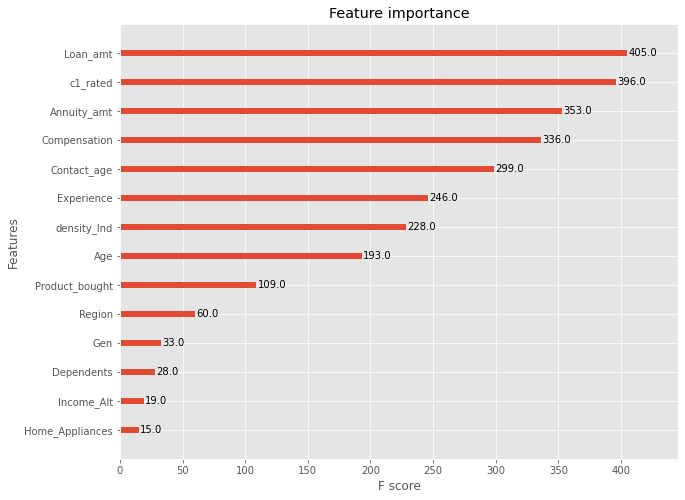

In [345]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

In [346]:
xgb_train_predict = xgb_model.predict(X_train)
xgb_test_predict = xgb_model.predict(X_test)

In [347]:
ytest_predict_prob=xgb_model.predict_proba(X_test)
Xtrmeboost_test_df=pd.DataFrame(ytest_predict_prob)

In [348]:
xgb_train_acc = xgb_model.score(X_train,y_train)
xgb_train_acc

0.7352449831924213

In [349]:
xgb_test_acc = xgb_model.score(X_test,y_test)
xgb_test_acc

0.732876991402844

In [350]:
xgb_metrics=classification_report(y_train, xgb_train_predict,output_dict=True)
xgb_train_df=pd.DataFrame(xgb_metrics).transpose()
xgb_train_f1=round(xgb_train_df.loc["1"][2],2)
xgb_train_recall=round(xgb_train_df.loc["1"][1],2)
xgb_train_precision=round(xgb_train_df.loc["1"][0],2)
print ('gbcl_train_precision ',xgb_train_precision)
print ('gbcl_train_recall ',xgb_train_recall)
print ('gbcl_train_f1 ',xgb_train_f1)

gbcl_train_precision  0.96
gbcl_train_recall  0.0
gbcl_train_f1  0.0


In [351]:
xgb_metrics=classification_report(y_test, xgb_test_predict,output_dict=True)
xgb_test_df=pd.DataFrame(xgb_metrics).transpose()
xgb_test_f1=round(xgb_test_df.loc["1"][2],2)
xgb_test_recall=round(xgb_test_df.loc["1"][1],2)
xgb_test_precision=round(xgb_test_df.loc["1"][0],2)
print ('gbcl_test_precision ',xgb_test_precision)
print ('gbcl_test_recall ',xgb_test_recall)
print ('gbcl_test_f1 ',xgb_test_f1)

gbcl_test_precision  0.5
gbcl_test_recall  0.0
gbcl_test_f1  0.0


In [352]:
X_train

,Compensation,Loan_amt,Annuity_amt,Age,density_Ind,Contact_age,c1_rated,Gen,Experience,Product_bought,Region,Dependents,Home_Appliances,Income_Alt
18546,0.46,0.59,0.57,0.35,0.65,0.77,0.32,0,0.40,2,0,2,4,1
66010,0.09,0.12,0.53,0.69,0.69,0.41,0.88,0,0.22,4,2,2,4,0
54831,0.21,0.11,0.44,0.96,0.58,0.09,0.37,0,0.19,3,2,2,4,0
4287,0.12,0.21,0.53,0.17,0.94,0.14,0.80,0,0.04,0,1,1,4,0
29600,0.22,0.24,0.71,0.67,0.10,0.15,0.51,1,0.36,4,3,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68163,0.25,0.23,0.48,0.71,0.40,0.26,0.51,0,0.09,3,3,2,4,0
92987,0.26,0.07,0.19,0.42,0.50,0.29,0.21,0,0.02,8,3,2,4,0
117513,0.28,0.33,0.46,0.42,0.18,0.33,0.79,1,0.33,2,2,2,4,0
57434,0.10,0.09,0.36,0.02,0.49,0.30,0.54,0,0.09,3,3,1,4,0


In [353]:
from sklearn.naive_bayes import GaussianNB

In [354]:
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)

GaussianNB()

In [355]:
NB_train_predict = NB_model.predict(X_train)
NB_train_acc = NB_model.score(X_train, y_train)   
NB_train_acc

0.7350005093205664

In [356]:
NB_test_predict = NB_model.predict(X_test)
NB_test_acc = NB_model.score(X_test, y_test)
NB_test_acc

0.732876991402844

In [357]:
NB_metrics=classification_report(y_train, NB_train_predict,output_dict=True)
NB_train_df=pd.DataFrame(NB_metrics).transpose()
NB_train_f1=round(NB_train_df.loc["1"][2],2)
NB_train_recall=round(NB_train_df.loc["1"][1],2)
NB_train_precision=round(NB_train_df.loc["1"][0],2)
print ('NB_train_precision ',NB_train_precision)
print ('NB_train_recall ',NB_train_recall)
print ('NB_train_f1 ',NB_train_f1)

NB_metrics=classification_report(y_test, NB_test_predict,output_dict=True)
NB_test_df=pd.DataFrame(NB_metrics).transpose()
NB_test_f1=round(NB_test_df.loc["1"][2],2)
NB_test_recall=round(NB_test_df.loc["1"][1],2)
NB_test_precision=round(NB_test_df.loc["1"][0],2)
print ('NB_test_precision ',NB_test_precision)
print ('NB_test_recall ',NB_test_recall)
print ('NB_test_f1 ',NB_test_f1)

NB_train_precision  0.0
NB_train_recall  0.0
NB_train_f1  0.0
NB_test_precision  0.0
NB_test_recall  0.0
NB_test_f1  0.0


In [358]:
print(classification_report(y_test, NB_test_predict))


              precision    recall  f1-score   support

           0       0.73      1.00      0.85     17987
           1       0.00      0.00      0.00      6556

    accuracy                           0.73     24543
   macro avg       0.37      0.50      0.42     24543
weighted avg       0.54      0.73      0.62     24543



In [143]:
all_lassifiers = ['Logistic Regression With Imbalance','Logistic Regression Without Imbalance', 'Decision Tree with Imbalance','Decision Tree without Imbalance', 'Random Forest with Imbalance','Random Forest without Imbalance']
all_train_accuracy = [train_accuracy_logi_with_imbalance, train_accuracy_logi_without_imbalance, train_accuracy_dtc_with_imbalance, train_accuracy_dtc_without_imbalance, train_accuracy_rfc_with_imbalance, train_accuracy_rfc_without_imbalance]
all_test_accuracy = [accuracy_logi_with_imbalabce, accuracy_logi_without_imbalance, accuracy_dtc_with_imbalance, accuracy_dtc_without_imbalance, accuracy_rfc_with_imbalance, accuracy_rfc_without_imbalance]
all_precision_score = [precision_score_logi_with_imbalance, precision_score_logi_without_imbalabce, precision_score_dtc_with_imbalance, precision_score_dtc_without_imbalance, precision_score_rfc_with_imbalance, precision_score_rfc_without_imbalance]
all_recall_score = [recall_score_logi_with_imbalance, recall_score_logi_without_imbalance, recall_score_dtc_with_imbalance, recall_score_dtc_without_imbalance, recall_score_rfc_with_imbalance, recall_score_rfc_without_imbalance]
all_f1_score = [f1_score_logi_with_imbalance, f1_score_logi_without_imbalance, f1_score_dtc_with_imbalance, f1_score_dtc_without_imbalance, f1_score_rfc_with_imbalance, f1_score_rfc_without_imbalance]
all_auc_score = [roc_score_logi_With_imbalance, roc_score_logi_without_imbalance, roc_score_dtc_with_imbalance, roc_score_dtc_without_imbalance, roc_score_rfc_with_imbalance, roc_score_rfc_without_imbalance]

In [144]:
compare_df = pd.DataFrame({'Classifier':all_lassifiers, 'Train Accuracy': all_train_accuracy, 'Test Accuracy': all_test_accuracy, 'Precision': all_precision_score, 'Recall': all_recall_score, 'F1 Score': all_f1_score , 'AUC': all_auc_score})
compare_df

,Classifier,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression With Imbalance,0.73,0.74,0.00,0.00,0.00,0.50
1,Logistic Regression Without Imbalance,0.58,0.58,0.34,0.27,0.30,0.50
2,Decision Tree with Imbalance,1.00,0.60,0.30,0.27,0.28,0.50
3,Decision Tree without Imbalance,1.00,0.56,0.36,0.26,0.30,0.50
4,Random Forest with Imbalance,1.00,0.73,0.01,0.28,0.02,0.51
5,Random Forest without Imbalance,1.00,0.65,0.18,0.27,0.21,0.50


In [145]:
# Predicting on test dataset

In [146]:
test =pd.read_csv('Test_Set_TVS.csv')

In [147]:
find_missing_values(test)

,Total,Percent
Experience,9351,0.16
c1_rated,7363,0.13
c2_rated,5655,0.10
Company_Rating,5053,0.09
Home_Appliances,4759,0.08
Job_Type,4320,0.08
Vehicle_Status,3883,0.07
Contact_age,3522,0.06
Income_Alt,3299,0.06
Compensation,2750,0.05


In [148]:
test=conditional_impute(test,'c1_rated','mean')
test=conditional_impute(test,'c2_rated','mean')
test=conditional_impute(test,'Company_Rating','mean')
test=conditional_impute(test,'Experience','median')
test=conditional_impute(test,'Home_Appliances','median')
test=conditional_impute(test,'Contact_age','median')
test=conditional_impute(test,'Compensation','median')
test=conditional_impute(test,'density_Ind','median')
test=conditional_impute(test,'Annuity_amt','median')
test=conditional_impute(test,'Job_Type','mode')
test=conditional_impute(test,'Vehicle_Status','mode')
test=conditional_impute(test,'Income_Alt','mode')
test=conditional_impute(test,'Credit_Inq','mode')
test=conditional_impute(test,'Prop_List','mode')

In [149]:
test['Compensation']=test['Compensation'].astype(int)
test['Loan_amt']=test['Loan_amt'].astype(int)
test['Home_Appliances']=test['Home_Appliances'].astype(int)
test['Dependents']=test['Dependents'].astype(int)
test['Company_Rating']=test['Company_Rating'].astype(int)
test['Age']=test['Age'].astype(int)
test['hour_Process']=test['hour_Process'].astype(int)
test['Product_bought']=test['Product_bought'].astype(int)



In [150]:
test=test[['Loan_amt','density_Ind','Contact_age','c1_rated','Experience','Product_bought','Region','Dependents','Home_Appliances','Income_Alt']]

In [151]:
# Transforming Categorical variable to Numerical Variable

def preprocess_data(data):
    
    test['Income_Alt'].replace(['Not_Specified', 'Y'],[0, 1], inplace=True)
    test['Region'].replace(['Central','East','North','South'],[0,1,2,3], inplace=True)
    
    
    return test

In [152]:
preprocess_data(test)

,Loan_amt,density_Ind,Contact_age,c1_rated,Experience,Product_bought,Region,Dependents,Home_Appliances,Income_Alt
0,809400,0.00,3133.00,0.35,5.40,2,2,3,1,0
1,72618,0.03,1730.00,0.24,2.30,5,0,2,4,1
2,267255,0.03,759.00,0.11,11.00,4,3,3,4,1
3,623600,0.03,609.00,0.32,9.70,4,1,2,4,1
4,529520,0.01,1222.00,0.94,4.60,1,2,2,4,1
...,...,...,...,...,...,...,...,...,...,...
56755,260085,0.01,215.00,0.72,3.60,7,2,1,4,0
56756,714467,0.03,22.00,0.51,15.10,0,1,2,4,1
56757,231420,0.03,776.00,0.17,0.30,5,1,3,2,0
56758,1096620,0.01,873.00,0.67,1.40,3,2,1,4,1


In [153]:
test.dtypes

Loan_amt             int32
density_Ind        float64
Contact_age        float64
c1_rated           float64
Experience         float64
Product_bought       int32
Region               int64
Dependents           int32
Home_Appliances      int32
Income_Alt           int64
dtype: object

In [154]:
# Predicting results using Decision Tree Model

In [155]:
# prediction=dtc.predict(test)

In [ ]:
'Loan_amt', 'density_Ind', 'Contact_age', 'c1_rated', 'Experience', 'Product_bought', 'Region', 'Dependents', 'Home_Appliances', 'Income_Alt'
'Loan_amt', 'density_Ind', 'Contact_age', 'c1_rated', 'Experience', 'Product_bought', 'Region', 'Dependents', 'Home_Appliances', 'Income_Alt', 'Default']

In [250]:
test.columns

Index(['Loan_amt', 'density_Ind', 'Contact_age', 'c1_rated', 'Experience', 'Product_bought', 'Region', 'Dependents', 'Home_Appliances', 'Income_Alt', 'Default'], dtype='object')

In [185]:
type(test)

pandas.core.frame.DataFrame

In [251]:
test=test[['Loan_amt','density_Ind','Contact_age','c1_rated','Experience','Product_bought','Region','Dependents','Home_Appliances','Income_Alt']]

In [252]:
test['Default']=xgb_model.predict(test)

In [157]:
test

,Loan_amt,density_Ind,Contact_age,c1_rated,Experience,Product_bought,Region,Dependents,Home_Appliances,Income_Alt,Default
0,809400,0.00,3133.00,0.35,5.40,2,2,3,1,0,0
1,72618,0.03,1730.00,0.24,2.30,5,0,2,4,1,0
2,267255,0.03,759.00,0.11,11.00,4,3,3,4,1,0
3,623600,0.03,609.00,0.32,9.70,4,1,2,4,1,1
4,529520,0.01,1222.00,0.94,4.60,1,2,2,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...
56755,260085,0.01,215.00,0.72,3.60,7,2,1,4,0,1
56756,714467,0.03,22.00,0.51,15.10,0,1,2,4,1,1
56757,231420,0.03,776.00,0.17,0.30,5,1,3,2,0,0
56758,1096620,0.01,873.00,0.67,1.40,3,2,1,4,1,1


In [253]:
df =pd.read_csv('Test_Set_TVS.csv')

In [254]:
df

,ID,Compensation,Vehicle_Status,Loan_amt,Annuity_amt,density_Ind,Job_Type,Default_hist,Prop_List,Home_Appliances,Region_Type,Credit_Inq,Education_det,Marital_Stat,Gen,Credit_Lnks,Experience,Income_Alt,Day_Process,Ph.No,Type_Loan,Dependents,Company_Rating,Region,Age,hour_Process,Addr_permanent,Permanent_Addr_tag,c1_rated,c2_rated,Contact_age,Product_bought
0,487410,653106.00,Y,809400.00,9145.51,0.00,Govt.,ndf,Morethan_One,1.00,Metro,1,Grad,Married,M,1_to_3,5.40,Not_Specified,thur,Yes,CLoan,3.00,2.00,North,39.00,11.00,Yes,Yes,0.35,0.35,3133.00,2.00
1,533258,434150.00,N,72618.75,7683.23,0.03,Govt.,ndf,One,4.00,Metro,1,Grad,Married,M,1_to_3,2.30,Y,wed,No,CLoan,2.00,3.00,Central,46.00,13.00,Yes,Yes,0.24,0.24,1730.00,5.00
2,581926,489060.00,N,267255.80,9032.85,0.03,IT,ndf,Morethan_One,NaN,Rural,1,Grad,Married,M,1_to_3,11.00,Y,thur,No,CLoan,3.00,2.00,South,33.00,15.00,Yes,Yes,0.11,0.11,759.00,4.00
3,486301,957294.00,N,623600.00,12838.25,0.03,IT,ndf,One,4.00,Metro,1,Grad,Married,M,1_to_3,9.70,Y,Tue,Yes,CLoan,2.00,2.00,East,48.00,12.00,Yes,Yes,0.32,0.32,609.00,4.00
4,580822,1333739.00,N,529520.00,11799.09,0.01,Non-IT,ndf,One,4.00,Metro,3,P_Grad,Married,F,1_to_3,NaN,Y,wed,Yes,RLoan,2.00,3.00,North,53.00,7.00,Yes,Yes,0.94,0.94,1222.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56755,513665,671640.00,N,260085.00,9654.50,0.01,IT,ndf,One,4.00,Metro,1,Grad,Single,F,1_to_3,3.60,Not_Specified,wed,Yes,CLoan,1.00,2.00,North,42.00,11.00,Yes,Yes,0.72,0.72,215.00,7.00
56756,450327,650680.00,N,714467.60,14063.75,0.03,NaN,ndf,One,NaN,Metro,1,Grad,Married,M,1_to_3,15.10,Y,Tue,Yes,CLoan,2.00,3.00,East,47.00,9.00,Yes,Yes,NaN,0.19,22.00,0.00
56757,476417,551374.00,NaN,231420.00,11299.78,0.03,Govt.,df,None,2.00,Metro,1,Grad,Divorce,M,1_to_3,0.30,Not_Specified,thur,Yes,RLoan,3.00,2.00,East,35.00,10.00,No,Yes,0.17,0.17,776.00,5.00
56758,461152,975117.00,N,1096620.00,10223.30,0.01,IT,ndf,One,4.00,Metro,2,Other,Single,M,>6,1.40,Y,mon,Yes,CLoan,1.00,1.00,North,22.00,13.00,Yes,No,0.67,0.67,873.00,3.00


In [255]:
df1=df[['ID']]

In [256]:
df1

,ID
0,487410
1,533258
2,581926
3,486301
4,580822
...,...
56755,513665
56756,450327
56757,476417
56758,461152


In [257]:
test

,Loan_amt,density_Ind,Contact_age,c1_rated,Experience,Product_bought,Region,Dependents,Home_Appliances,Income_Alt,Default
0,809400,0.00,3133.00,0.35,5.40,2,2,3,1,0,0
1,72618,0.03,1730.00,0.24,2.30,5,0,2,4,1,0
2,267255,0.03,759.00,0.11,11.00,4,3,3,4,1,0
3,623600,0.03,609.00,0.32,9.70,4,1,2,4,1,0
4,529520,0.01,1222.00,0.94,4.60,1,2,2,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...
56755,260085,0.01,215.00,0.72,3.60,7,2,1,4,0,1
56756,714467,0.03,22.00,0.51,15.10,0,1,2,4,1,1
56757,231420,0.03,776.00,0.17,0.30,5,1,3,2,0,1
56758,1096620,0.01,873.00,0.67,1.40,3,2,1,4,1,0


In [258]:
df2 = pd.concat([test, df1], axis=1)

In [259]:
df2

,Loan_amt,density_Ind,Contact_age,c1_rated,Experience,Product_bought,Region,Dependents,Home_Appliances,Income_Alt,Default,ID
0,809400,0.00,3133.00,0.35,5.40,2,2,3,1,0,0,487410
1,72618,0.03,1730.00,0.24,2.30,5,0,2,4,1,0,533258
2,267255,0.03,759.00,0.11,11.00,4,3,3,4,1,0,581926
3,623600,0.03,609.00,0.32,9.70,4,1,2,4,1,0,486301
4,529520,0.01,1222.00,0.94,4.60,1,2,2,4,1,0,580822
...,...,...,...,...,...,...,...,...,...,...,...,...
56755,260085,0.01,215.00,0.72,3.60,7,2,1,4,0,1,513665
56756,714467,0.03,22.00,0.51,15.10,0,1,2,4,1,1,450327
56757,231420,0.03,776.00,0.17,0.30,5,1,3,2,0,1,476417
56758,1096620,0.01,873.00,0.67,1.40,3,2,1,4,1,0,461152


In [260]:
df2=df2[['ID','Default']]

In [261]:
df2

,ID,Default
0,487410,0
1,533258,0
2,581926,0
3,486301,0
4,580822,0
...,...,...
56755,513665,1
56756,450327,1
56757,476417,1
56758,461152,0


In [262]:
df2.to_csv('Sample_Submission_TVS.csv')

# Descriptive Section
Q) Once you have a mechanism to estimate the “level of default”, please describe how the financial institution must use that mechanism to decide whether to approve or decline the prospect for the loan they are applying for.

# Answer
# We can implement this model in during the Credit application appraisal process when a customer applied for Auto-Loan.
The important features used Loan_amt,density_Ind,Contact_age,c1_rated,Experience,Product_bought,Region,Dependents,Home_Appliances & Income_Alt will be captured in the loan application. We can pass those values to this model and get the probability of default by interacting with the model in Json

Batch wise prediction can be also done by uploading the customer's information and get the Probability of Default.

Ensure: All the variables are collected without any missing values